# SG Reits + STI Cross-Sectional Momentum Backtest

Alrighty, I have an idea that I want to try out. Basically, we would like to conduct a backtest on all Singapore reits + STI constituents leveraging upon the cross-sectional momentum anomaly.

The basic idea is to rank these stocks based on their past 12-2, 12-7, 6-2 and 2-1 months cumulative return, and go long the top 10% of stocks and short the bottom 10%. We will also examine a variety of holding periods including 1 month, 3 months and 6 months. Subsequently, we will compare the performance of our strategy to the STI index. 

## Processing the data

First, we will be downloading the historical data of the stocks from yahoo finance. We will write several helper functions in order to download our data from yahoo, standardize the index, calculate the past x months returns, rank them accordingly, create a new signal column for our dataframe, before adjusting the data to account for dividends and splits. 

After which, we will pass the data into our backtester and check out our results using Pyfolio!

In [1]:
# We hate warnings
import warnings
warnings.simplefilter('ignore')

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
from scipy.stats import rankdata

Our first function to get data from yahoo!

In [2]:
def get_yahoo_data(names, tickers, start, end):
    # Pass in a list of stock tickers together with a list of user defined stock names
    # the function will fetch the daily OHLC data of that stock ticker from yahoo and 
    # return it in a dictionary with the name as the key, and the daily stock data 
    # in a dataframe as the value.
    
    # Override existing pandas yahoo api
    yf.pdr_override()
    
    # Create an empty dictionary
    d = {}
    
    # Reindex our columns
    cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    
    # Iterate through the names and tickers
    for name, ticker in zip(names, tickers):
        df = pdr.get_data_yahoo(ticker, start=start, 
                                  end=end)
        df = df.reindex(columns=cols)
        d[name] = df
    
    return d

Next, we would like to ensure that our data has the same working timeframe. In order to accomplish this, we will be standardizing our index according to the business day calendar.

In [3]:
def standardize_index(raw_dict, start, end, method='ffill'):
    # Pass in a dictionary, with the keys as the stock names and values
    # as the stock daily data. This function will create a master index from the
    # start date till the end date with the list of all business days, and standardize 
    # the datetime index for all the other stocks. Moreover, by default, this function will apply forward fill
    # for all the missing values in the dataframe after the start date of that particular
    # stock data.
    
    # Create a new dictionary
    d = {}
    
    # Create a master index 
    master_index = pd.date_range(start, end, freq='B')
    
    for key in raw_dict.keys():
        # Get the starting day index of the stock (i.e. the day it started trading)
        start_date_index = raw_dict[key].index[0]
        
        # Standardize the index
        d[key] = raw_dict[key].reindex(master_index)
        d[key].sort_index(inplace=True)
            
        # Seperate the dataframe into two seperate dataframe, before start date and after
        # start date. For the dates after the start date, if there are NaN values, we will 
        # be using the method specified to fill in the values
        before = d[key].loc[:start_date_index]
        after = d[key].loc[start_date_index + BDay(1):]
        after.fillna(method=method, inplace=True)
        # Concatenate the matrices and assign them accordingly
        d[key] = pd.concat([before, after]).copy()
    
    return d

Next, we will look to calculate the cumulative returns. Note that for MOM 12-2, we will be calculating the absolute return from the last 12 month to the last 2 month. 

To do so, we will first resample the data and change it into a monthly timeframe before performing our calulation. Do note that we will be performing our calculations based on the end of month adjusted prices.

In [4]:
def lookback_returns(raw_dict, n, m, col='Adj Close'):
    # Pass in a raw dictionary and specify the lookback_period in months. This
    # function will calculate the M(lookback_period) - 12 cumulative returns
    # and return it in a dataframe with the same dimensions

    # Create a new dictionary
    d = {}
    
    # Create a empty dataframe to store all the returns
    returns = pd.DataFrame()
    
    # Resampling our daily data into monthly timeframe (end of month)
    for key in raw_dict.keys():
        d[key] = raw_dict[key].resample('M').last()

        # Caculate the n lookback monthly returns using Adjusted Close (note returns 
        # are calculated using end of month data)
        returns[key] = (d[key][col].shift(m-1) / d[key][col].shift(n)) - 1
    
    return returns

After calculating the cumulative returns, the next step would be to rank the stocks accordingly.

In [5]:
def rank_returns(returns_dict):
    # Pass in a raw dictioary specifying the lookback_returns of the stocks. The
    # function will rank them accordingly and return a dataframe of the same dimension
    # with the ranking for each row

    # Use rankdata and apply_along_axis to create a np matrix of rankings
    rank = np.apply_along_axis(rankdata, 1, returns_dict)
    
    # Put the rankings into a pandas dataframe
    ranked_returns = pd.DataFrame(rank, columns=returns_dict.columns,
                                 index=returns_dict.index)
    
    return ranked_returns

In [6]:
def top_percentile_rank_returns(returns_dict, n):
    # Pass in a raw dictionary specificying the returns of the stocks, with the names of the stock
    # as the column headers. This function will rank them accordingly and for the top n percentile
    # of stocks, the function will return 1 and 0 otherwise. 
    
    # Get a dataframe of the returns ranking
    ranked_returns = rank_returns(returns_dict)
    
    # Get a panda series of the count
    count = returns_dict.count(axis=1)
    
    # Label the top n percentile of stocks with 1 and 0 for the rest
    top_percentile_ranked_returns = ranked_returns.apply(lambda x: x <= np.round(n*count)).astype('int')
    
    # Change the date to the start of the month
    top_percentile_ranked_returns.index = top_percentile_ranked_returns.index - pd.DateOffset(day=1)
    
    # Lag the signal by one month
    top_percentile_ranked_returns = top_percentile_ranked_returns.shift(1)
    
    return top_percentile_ranked_returns

Now at this juncture, our function will calculate the cumulative returns for our stocks and rank them accordingly. After which, it will create a new columns called 'Signal', which will only accept a binary value, with 1 indicating that it should be in our portfolio at the start of that particular month, and 0 otherwise.

Now, for every stock, we will merge the 'Signal' column with the initial dataframe.

In [7]:
def create_signal(raw_dict, top_p_ranked_returns):
    # Pass in a raw dictionary with the keys as the stock names and the values as a pandas
    # dataframe containing the stocks daily values, as well as a result providing the 
    # name of the stocks with the best past x months return. This function will return the 
    # raw dictionary dataframe with a new binary column 'signal', with 1 indicating that the
    # stock should be included in the portfolio and 0 otherwise
    
    # Create an empty dictionary to store our final output
    d = {}
    
    # Refer to the master index
    master_index = list(raw_dict.values())[0].index
    
    # Use forward fill to extend the montly ranking series to daily serires
    master_index.name = 'date'
    top_p_ranked_returns = top_p_ranked_returns.reindex(master_index, method='ffill')
    
    # Merge the rankings with the original stock dataframe and rename it as signal
    for key in raw_dict.keys():
        signal = top_p_ranked_returns[key]
        signal.name = 'Signal'
        d[key] = raw_dict[key].join(signal, how='inner')
    
    return d

Next, we will adjust the Open, High, Low and Volume according to the Adj Close provided by yahoo finance to account for any dividends and splits that took place.

In [8]:
def adj_yahoo_data(raw_dict):
    # Pass in raw unadjusted yahoo data as well as Adj Close prices. This function
    # will adjust the Open, High, Low and Volume column according to the Adj Close prices
    
    # create a new dictionary
    d = {}
    
    for key in raw_dict.keys():
        # Calculate the params to adjust OHLC prices 
        param = raw_dict[key]['Adj Close'] / raw_dict[key]['Close']
        d[key] = raw_dict[key].copy()
    
        # Adjust the OHL and volume
        d[key]['Volume'] = d[key]['Volume'].div(param, axis=0)
        d[key][['Open', 'High', 'Low']] = d[key][['Open', 'High', 'Low']].mul(param, 
                                                                                  axis=0)
        # Drop the column close and rename Adj Close as Close
        d[key].drop(['Close'], axis=1, inplace=True)
        d[key].rename({'Adj Close' : 'Close'}, axis='columns', inplace=True)
    
        # Fill the NaNs with 0 to load into our backtrader
        d[key].fillna(0, inplace=True)
        
    return d

Finally, we will include a helper function to shift the period of our reits data to our desired backtesting period.

In [9]:
def adjust_backtest_dates(raw_dict, start, end):
    
    # Create a new dictionary
    d = {}
    
    for key in raw_dict.keys():
        d[key] = raw_dict[key].loc[start:end]
    
    return d

## Pyfolio

Now, let's import pyfolio and create our custom tear sheet. This will be very useful when we want to showcase our backtesting results later on.

In [10]:
import pyfolio as pf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

def create_custom_tear_sheet(returns, positions=None,
                              transactions=None,
                              live_start_date=None,
                              cone_std=(1.0, 1.5, 2.0),
                              benchmark_rets=None,
                              bootstrap=False,
                              turnover_denom='AGB',
                              header_rows=None,
                              return_fig=False):
    """
    Generate a number of plots for analyzing a strategy's returns.
    - Fetches benchmarks, then creates the plots on a single figure.
    - Plots: rolling returns (with cone), rolling beta, rolling sharpe,
        rolling Fama-French risk factors, drawdowns, underwater plot, monthly
        and annual return plots, daily similarity plots,
        and return quantile box plot.
    - Will also print the start and end dates of the strategy,
        performance statistics, drawdown periods, and the return range.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in create_full_tear_sheet.
    positions : pd.DataFrame, optional
        Daily net position values.
         - See full explanation in create_full_tear_sheet.
    transactions : pd.DataFrame, optional
        Executed trade volumes and fill prices.
        - See full explanation in create_full_tear_sheet.
    live_start_date : datetime, optional
        The point in time when the strategy began live trading,
        after its backtest period.
    cone_std : float, or tuple, optional
        If float, The standard deviation to use for the cone plots.
        If tuple, Tuple of standard deviation values to use for the cone plots
         - The cone is a normal distribution with this standard deviation
             centered around a linear regression.
    benchmark_rets : pd.Series, optional
        Daily noncumulative returns of the benchmark.
         - This is in the same style as returns.
    bootstrap : boolean, optional
        Whether to perform bootstrap analysis for the performance
        metrics. Takes a few minutes longer.
    turnover_denom : str, optional
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    header_rows : dict or OrderedDict, optional
        Extra rows to display at the top of the perf stats table.
    return_fig : boolean, optional
        If True, returns the figure that was plotted on.
    """

    returns = returns[returns.index > benchmark_rets.index[0]]

    pf.show_perf_stats(returns, benchmark_rets)

    pf.show_worst_drawdown_periods(returns)

    # If the strategy's history is longer than the benchmark's, limit strategy
    if returns.index[0] < benchmark_rets.index[0]:
        returns = returns[returns.index > benchmark_rets.index[0]]

    vertical_sections = 12

    if live_start_date is not None:
        vertical_sections += 1
        live_start_date = ep.utils.get_utc_timestamp(live_start_date)

    if bootstrap:
        vertical_sections += 1

    fig = plt.figure(figsize=(14, vertical_sections * 6))
    gs = gridspec.GridSpec(vertical_sections, 3, wspace=0.5, hspace=0.5)
    ax_rolling_returns = plt.subplot(gs[:2, :])

    i = 2
    ax_rolling_returns_vol_match = plt.subplot(gs[i, :],
                                               sharex=ax_rolling_returns)
    i += 1
    ax_rolling_returns_log = plt.subplot(gs[i, :],
                                         sharex=ax_rolling_returns)
    i += 1
    ax_returns = plt.subplot(gs[i, :],
                             sharex=ax_rolling_returns)
    i += 1
    ax_rolling_beta = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_volatility = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_rolling_sharpe = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_drawdown = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_underwater = plt.subplot(gs[i, :], sharex=ax_rolling_returns)
    i += 1
    ax_monthly_heatmap = plt.subplot(gs[i, 0])
    ax_annual_returns = plt.subplot(gs[i, 1])
    ax_monthly_dist = plt.subplot(gs[i, 2])
    i += 1
    ax_return_quantiles = plt.subplot(gs[i, :])
    i += 1

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns)
    ax_rolling_returns.set_title(
        'Cumulative returns')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        live_start_date=live_start_date,
        cone_std=None,
        volatility_match=True,
        legend_loc=None,
        ax=ax_rolling_returns_vol_match)
    ax_rolling_returns_vol_match.set_title(
        'Cumulative returns volatility matched to benchmark')

    pf.plot_rolling_returns(
        returns,
        factor_returns=benchmark_rets,
        logy=True,
        live_start_date=live_start_date,
        cone_std=cone_std,
        ax=ax_rolling_returns_log)
    ax_rolling_returns_log.set_title(
        'Cumulative returns on logarithmic scale')

    pf.plot_returns(
        returns,
        live_start_date=live_start_date,
        ax=ax_returns,
    )
    ax_returns.set_title(
        'Returns')

    pf.plot_rolling_beta(
        returns, benchmark_rets, ax=ax_rolling_beta)

    pf.plot_rolling_volatility(
        returns, factor_returns=benchmark_rets, ax=ax_rolling_volatility)

    pf.plot_rolling_sharpe(
        returns, ax=ax_rolling_sharpe)

    # Drawdowns
    pf.plot_drawdown_periods(
        returns, top=5, ax=ax_drawdown)

    pf.plot_drawdown_underwater(
        returns=returns, ax=ax_underwater)

    pf.plot_monthly_returns_heatmap(returns, ax=ax_monthly_heatmap)
    pf.plot_annual_returns(returns, ax=ax_annual_returns)
    pf.plot_monthly_returns_dist(returns, ax=ax_monthly_dist)

    pf.plot_return_quantiles(
        returns,
        live_start_date=live_start_date,
        ax=ax_return_quantiles)

    if bootstrap:
        ax_bootstrap = plt.subplot(gs[i, :])
        pf.plot_perf_stats(returns, benchmark_rets,
                                 ax=ax_bootstrap)

    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), visible=True)

    plt.show()
    if return_fig:
        return fig
    else:
        plt.close(fig)


## Backtesting our strategy

Now that we have written our helper functions, it is time to specify the names of our stocks, their respective tickers as well as the start date and end date for our data. Below, we have chosen a total of 36 reits + 22 STI stocks listed in Singapore who are denominated in SGD, and we have chosen to download the data from June 2009 to January 2018.

In [16]:
# Load the packages neccessary to run backtrader
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.filters as btfilters

%matplotlib inline

In [11]:
# Create a list of stocks and their respective tickers
reit_names = ['AIMS', 'Ascendas', 'Ascendas_Hos', 'Ascott', 'BHG', 'Cache', 'Captland_Comm',
         'Captland_Mall', 'Captret_China', 'CDL_Hos', 'Cromwell', 'EC_World',
         'ESR', 'Far_East_Hos', 'First', 'Frasers_Cpoint', 'Fraser_Comm', 'Frasers_Hos', 'Frasers_Log',
         'IREIT', 'Keppel_Dc', 'Keppel', 'Lippo_Mall', 'Mapletree_Comm', 'Mapletree_Gcc',
         'Mapletree_Ind', 'Mapletree_Log', 'OUE_Comm', 'OUE_Hos', 'Parkway', 'Sabana',
         'Soilbuild', 'SPH', 'Starhill', 'Suntec', 'Viva']

reit_tickers = ['O5RU.SI', 'A17U.SI', 'Q1P.SI', 'A68U.SI', 'BMGU.SI', 'K2LU.SI', 'C61U.SI', 
           'C38U.SI', 'AU8U.SI', 'J85.SI', 'CNNU.SI', 'BWCU.SI', 'J91U.SI', 
           'Q5T.SI', 'AW9U.SI', 'J69U.SI', 'ND8U.SI', 'ACV.SI', 'BUOU.SI', 'UD1U.SI', 
           'AJBU.SI', 'K71U.SI', 'D5IU.SI', 'N2IU.SI', 'RW0U.SI', 'ME8U.SI', 'M44U.SI',
          'TS0U.SI', 'SK7.SI', 'C2PU.SI', 'M1GU.SI', 'SV3U.SI', 'SK6U.SI', 'P40U.SI',
          'T82U.SI', 'T8B.SI']


index_names = ['OCBC', 'Capitaland', 'CityDev', 'ComfortDelGro', 'DBS', 'Genting', 'Golden_Agri', 'Jardine_C&C',
             'Keppel_Corp', 'SATS', 'Sembcorp_Ind', 'SGX', 'SIA', 'Singtel', 'Singapore_Press', 'ST_Engineering',
             'Starhub', 'UOB', 'UOL', 'Venture', 'Wilmar', 'YZJ']

index_tickers = ['O39.SI', 'C31.SI', 'C09.SI', 'C52.SI', 'D05.SI', 'G13.SI', 'E5H.SI', 'C07.SI', 'BN4.SI', 
               'S58.SI', 'U96.SI', 'S68.SI', 'C6L.SI', 'Z74.SI', 'T39.SI', 'S63.SI', 'CC3.SI', 'U14.SI', 'U14.SI', 
               'V03.SI', 'F34.SI', 'BS6.SI']

names = reit_names + index_names
tickers = reit_tickers + index_tickers

# Set the index, we will be using the Straits Time Index for our study
index_name = ['STI']
index_ticker = ['ES3.SI']

# Set the start date and the end date for our data
start = '2009-01-01'
end = '2018-01-31'

# Time to use our helper functions
reits_raw = get_yahoo_data(names=names, tickers=tickers, start=start, end=end)
index_raw = get_yahoo_data(names=index_name, tickers=index_ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*******************

In [21]:
# Standardize the index
reits_standardized = standardize_index(reits_raw, start=start, end=end)
index_standardized = standardize_index(index_raw, start=start, end=end)

In [48]:
from collections import OrderedDict

# Set the top 10 percentile of stocks to be included in our portfolio 
n = 0.1

# Start date and end date of backtest
bt_start_date = '2010-12-31'
bt_end_date = '2018-01-31'

# Set the lookback_period to calculate the past returns
lookback_period = [(12, 2) , (12, 7), (6, 2), (6, 1), (2, 1)]

# Create lists to store our raw_data
raw_datas_names = ['MOM 12-2', 'MOM 12-7', 'MOM 6-2', 'MOM 6-1', 'MOM 2-1']
raw_datas = []

# Loop through all the variation that we want to test
for i, j in lookback_period:
    reits_returns = lookback_returns(reits_standardized, i, j)
    top_p_rank_returns = top_percentile_rank_returns(reits_returns, n)
    bottom_p_rank_returns = top_percentile_rank_returns(-reits_returns, n)
    combined_p_rank_returns = top_p_rank_returns - bottom_p_rank_returns
    reits = create_signal(reits_standardized, combined_p_rank_returns)
    adj_reits = adj_yahoo_data(reits)
    reits_backtest_data = adjust_backtest_dates(adj_reits, bt_start_date, bt_end_date)
    raw_datas.append(reits_backtest_data)
    
# Create an ordered dictionary storing all our processed data
full_raw_dict = OrderedDict(zip(raw_datas_names, raw_datas))

In [49]:
# Adjust the index for splits and dividends accordingly
adj_index = adj_yahoo_data(index_standardized)
index_backtest_data = adjust_backtest_dates(adj_index, bt_start_date, bt_end_date)

In [50]:
# Create a custom extended PandasData feed 
class CustomDataLoader(bt.feeds.PandasData):
    lines = ('signal',)
    params = (('signal', -1), # Set the expected position of the column 'Signal'
             )
    
    datafields = bt.feeds.PandasData.datafields + (['Signal'])

In [51]:
# Create a copy of STI returns
STI = index_backtest_data['STI'].copy()

# Calculate the returns
sti_rets = STI['Close'].pct_change().fillna(0)
sti_rets.index = sti_rets.index.tz_localize('utc')

In [52]:
# Define our NewMomentum Strategy 
class NewMomentumStrategy(bt.Strategy):
    params = (('period', 1), 
             ('lpositions', 1),
              ('spositions', 1),
             )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        
    def notify_order(self, order):
        if order.status == order.Completed:
            n = order.info.name
            size = order.size
            if order.isbuy():
                self.log('Buy ' + str(size) + ' ' + str(n))
                
            else:
                self.log('Sell ' + str(-size) + ' ' + str(n))
        
        elif order.status == order.Rejected:
            self.log('Order is rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def start(self):
        self.order = None
    
    def next(self):

        #start of backtesting period
        b_test_start = '12/31/2010'
        
        # end of backtesting period
        b_test_end = '1/1/2018'
        
        # End of the business month for Singapore timezone to rebalance 
        # our portfolio (vary from 1Q, 2Q, 4Q)
        end_date_range = pd.date_range(b_test_start, b_test_end, 
                                   freq='BM', tz='Asia/Singapore')[::self.p.period]
    
        # We will be rebalancing our portfolio every month 
        if self.datas[0].datetime.date(0) in end_date_range:
            # Simply log the closing price of the series from the reference
            self.log('Close ' + '%.2f '*len(self.datas) % (tuple(self.datas[i].close[0]
                                                            for i in range(len(self.datas)))))
            
            # log the positions
            self.log('Current Positions: '+ '%d '*len(self.datas) % tuple([self.getposition(self.datas[i]).size 
                                          for i in range(len(self.datas))]))
            
            # list of stocks to buy 
            target_buy = [i for i in range(len(self.datas)) if self.datas[i].signal[1] > 0]
            
            # list of stocks to short
            target_short = [i for i in range(len(self.datas)) if self.datas[i].signal[1] < 0]
            
            # Log the number of stocks to be bought
            self.p.lpositions = len(target_buy)
            
            # Log the number of stocks to be sold
            self.p.spositions = len(target_short)
            
            # list of stocks to sell
            target_sale = [i for i in range(len(self.datas)) if i not in target_buy+target_short]                                    
            
            for j in target_sale:
                # if there is an existing position, sell the stock
                if not self.getposition(self.datas[j]).size == 0:
                    self.order = self.order_target_size(target=0, 
                                                        data=self.datas[j])
                    if self.order is not None:
                        self.order.addinfo(name=self.datas[j]._name)
                        
            for i in target_buy:
                # buy the stock according to the number of stocks in our target_buy list
                self.order = self.order_target_percent(target=np.round(0.97/self.p.lpositions, 2), 
                                                          data=self.datas[i],
                                                      price=self.datas[i].high[1],
                                                       exectype=bt.Order.Limit)
                if self.order is not None:
                    self.order.addinfo(name=self.datas[i]._name)
                    
            for i in target_short:
                # short the stock according to the number of stocks in our target_short list
                self.order = self.order_target_percent(target=-np.round(0.97/self.p.spositions, 2), 
                                                          data=self.datas[i],
                                                      price=self.datas[i].high[1],
                                                       exectype=bt.Order.Limit)
                if self.order is not None:
                    self.order.addinfo(name=self.datas[i]._name)

Starting Portfolio Value: 100000.00
Currently testing strategy MOM 12-2
2010-12-31, Close 2.22 0.78 29.12 0.00 4.00 0.31 6.34 1.17 1.30 0.30 7.31 3.02 1.25 11.73 0.00 0.00 0.00 2.20 4.11 1.97 7.26 0.41 0.00 4.83 0.00 11.03 1.71 0.52 0.00 0.40 0.00 0.00 0.96 0.00 0.00 0.61 12.77 0.84 0.50 0.00 0.66 2.75 1.36 0.00 1.18 0.68 0.99 1.32 0.59 0.70 1.00 0.43 0.00 0.00 4.00 5.94 0.00 3.03 
2010-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
2011-01-03, Buy 4928 Wilmar
2011-01-03, Buy 2143 DBS
2011-01-03, Buy 20000 ComfortDelGro
2011-01-03, Buy 7821 Capitaland
2011-01-03, Sell 800 Jardine_C&C
2011-01-03, Sell 11988 Genting
2011-01-03, Sell 17073 YZJ
2011-01-03, Sell 33446 Golden_Agri
2011-06-30, Close 2.30 0.82 35.02 0.00 4.28 0.37 5.73 1.34 1.32 0.29 8.05 3.01 1.27 9.78 0.00 0.00 0.00 1.99 4.10 1.73 6.99 0.41 0.00 4.67 0.00 11.50 1.88 0.53 0.00 0.43 0.00 0.00 0.93 0.00 0.00 0.61 11.83 0.81 0.52 0.57

2014-07-01, Buy 5503 Singtel
2014-07-01, Sell 538 Jardine_C&C
2014-07-01, Buy 1150 DBS
2014-07-01, Buy 5083 Starhub
2014-07-01, Buy 46693 Lippo_Mall
2014-07-01, Sell 415 CityDev
2014-07-01, Buy 24887 Ascendas_Hos
2014-07-01, Buy 13434 AIMS
2014-07-01, Buy 4231 ST_Engineering
2014-07-01, Sell 10919 Captland_Comm
2014-07-01, Sell 13068 Mapletree_Comm
2014-07-01, Buy 2275 YZJ
2014-07-01, Sell 6531 ComfortDelGro
2014-07-01, Sell 9535 Suntec
2014-07-01, OPERATION PROFIT, GROSS -876.34, NET -1382.76
2014-07-01, OPERATION PROFIT, GROSS 3967.28, NET 3964.26
2014-07-01, OPERATION PROFIT, GROSS 29.28, NET -476.84
2014-07-01, OPERATION PROFIT, GROSS 231.39, NET -274.96
2014-12-31, Close 3.41 1.32 37.75 0.60 6.39 0.27 6.88 2.03 1.92 0.52 7.58 3.71 1.34 9.91 0.85 0.00 0.80 2.74 4.02 0.99 9.25 0.58 0.00 2.96 0.59 18.29 3.37 1.13 0.53 0.65 0.59 0.66 1.37 0.73 0.00 1.06 10.64 1.02 0.82 1.14 1.20 3.00 1.03 0.00 2.28 0.98 1.63 1.69 0.94 0.43 1.56 1.01 0.59 0.65 6.39 6.50 0.57 2.94 
2014-12-31, Current P

2017-07-03, OPERATION PROFIT, GROSS -2132.43, NET -2134.35
2017-07-03, OPERATION PROFIT, GROSS -696.47, NET -880.09
2017-07-03, OPERATION PROFIT, GROSS -2664.90, NET -3304.70
2017-07-03, OPERATION PROFIT, GROSS 769.15, NET 767.83
2017-07-03, OPERATION PROFIT, GROSS 683.70, NET 500.18
2017-07-03, OPERATION PROFIT, GROSS 2710.43, NET 2708.95
2017-12-29, Close 3.57 1.61 39.58 0.90 8.69 0.39 7.35 2.93 2.65 0.54 7.23 2.59 1.65 12.41 1.01 0.73 1.37 5.20 3.01 1.29 12.21 0.38 0.76 3.02 0.83 24.36 2.75 1.45 0.83 0.75 0.75 0.77 1.85 1.17 1.12 1.33 10.67 1.23 0.82 1.58 1.98 3.17 1.41 0.56 1.93 1.20 2.10 2.07 1.27 0.37 2.18 1.37 0.64 0.70 8.69 19.89 0.70 3.39 
2017-12-29, Current Positions: 1660 0 0 0 0 0 0 0 0 0 0 1989 0 -686 0 8492 0 0 0 -7008 0 0 0 0 0 -367 2439 0 0 0 0 0 0 0 0 0 624 0 0 0 0 0 -6109 0 2831 0 0 0 0 0 0 0 0 0 0 -631 0 0 
2018-01-01, Sell 8492 BHG
2018-01-01, Buy 367 DBS
2018-01-01, Sell 2439 Starhub
2018-01-01, Sell 624 SIA
2018-01-01, Sell 493 Singtel
2018-01-01, Buy 104 Jardine

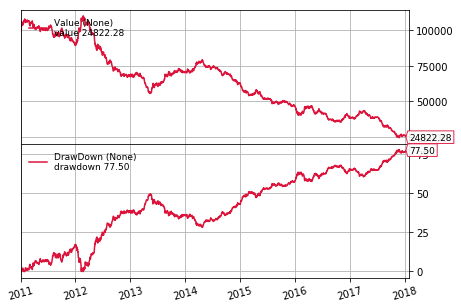

Sharpe Ratio:  -1.1282593556650102
SQN:  -2.155816160751016
Final Portfolio Value: 24822.28


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 12-7
2010-12-31, Close 2.22 0.78 29.12 0.00 4.00 0.31 6.34 1.17 1.30 0.30 7.31 3.02 1.25 11.73 0.00 0.00 0.00 2.20 4.11 1.97 7.26 0.41 0.00 4.83 0.00 11.03 1.71 0.52 0.00 0.40 0.00 0.00 0.96 0.00 0.00 0.61 12.77 0.84 0.50 0.00 0.66 2.75 1.36 0.00 1.18 0.68 0.99 1.32 0.59 0.70 1.00 0.43 0.00 0.00 4.00 5.94 0.00 3.03 
2010-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
2011-01-03, Buy 3696 SGX
2011-01-03, Buy 18314 Ascendas
2011-01-03, Buy 2143 DBS
2011-01-03, Buy 7821 Capitaland
2011-01-03, Sell 800 Jardine_C&C
2011-01-03, Sell 79317 ESR
2011-01-03, Sell 5760 Sembcorp_Ind
2011-01-03, Sell 17073 YZJ
2011-06-30, Close 2.30 0.82 35.02 0.00 4.28 0.37 5.73 1.34 1.32 0.29 8.05 3.01 1.27 9.78 0.00 0.00 0.00 1.99 4.10 1.73 6.99 0.41 0.00 4.67

2014-01-01, OPERATION PROFIT, GROSS 94.94, NET -585.47
2014-01-01, OPERATION PROFIT, GROSS 0.01, NET -680.39
2014-06-30, Close 3.23 1.18 39.06 0.57 5.99 0.30 5.95 1.97 1.80 0.58 9.15 3.61 1.32 9.83 0.81 0.00 0.00 2.70 4.81 1.22 8.05 0.62 0.00 2.89 0.54 14.64 3.31 1.06 0.56 0.65 0.00 0.00 1.29 0.65 0.00 1.04 9.36 1.03 0.81 1.08 1.12 3.32 0.92 0.00 2.16 0.91 1.47 1.59 0.90 0.52 1.53 0.93 0.57 0.67 5.99 6.40 0.55 2.84 
2014-06-30, Current Positions: -8310 24297 0 0 -4593 0 0 0 0 0 0 0 0 2791 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 50394 0 -31611 0 0 -4593 0 0 9695 
2014-07-01, Buy 8310 Singtel
2014-07-01, Sell 24297 Captret_China
2014-07-01, Buy 4593 UOL
2014-07-01, Sell 50394 Golden_Agri
2014-07-01, Buy 4593 UOB
2014-07-01, Sell 9695 Capitaland
2014-07-01, Buy 495 Jardine_C&C
2014-07-01, Buy 64354 Lippo_Mall
2014-07-01, Sell 816 CityDev
2014-07-01, Buy 34301 Ascendas_Hos
2014-07-01, Buy 52172 First
2014-07-01, Sell 4031 Sembcorp_Ind
2014-07-01, Sell 15856 Ge

2017-01-02, Buy 5544 ComfortDelGro
2017-01-02, Buy 2188 UOB
2017-01-02, Sell 37750 Lippo_Mall
2017-01-02, Sell 13398 Keppel
2017-01-02, Sell 9955 Mapletree_Comm
2017-01-02, Sell 8389 Mapletree_Ind
2017-01-02, Sell 8372 Suntec
2017-01-02, Sell 7299 Frasers_Cpoint
2017-01-02, OPERATION PROFIT, GROSS -2113.67, NET -2629.94
2017-01-02, OPERATION PROFIT, GROSS 392.41, NET 389.67
2017-01-02, OPERATION PROFIT, GROSS -4981.77, NET -5984.71
2017-01-02, OPERATION PROFIT, GROSS -4185.00, NET -4188.15
2017-01-02, OPERATION PROFIT, GROSS 2149.83, NET 2146.95
2017-01-02, OPERATION PROFIT, GROSS -1294.35, NET -1814.24
2017-01-02, OPERATION PROFIT, GROSS 856.80, NET 337.23
2017-01-02, OPERATION PROFIT, GROSS -3088.39, NET -3608.24
2017-06-30, Close 3.72 1.59 42.90 0.82 7.49 0.43 7.08 2.57 2.46 0.55 6.11 3.13 1.52 10.66 0.93 0.73 1.22 4.94 3.03 1.05 10.47 0.43 0.78 3.25 0.70 20.02 2.55 1.35 0.78 0.73 0.71 0.69 1.50 0.99 1.01 1.38 9.92 1.10 0.82 1.51 1.78 3.53 1.14 0.00 2.19 1.11 1.78 1.87 1.12 0.37 2.0

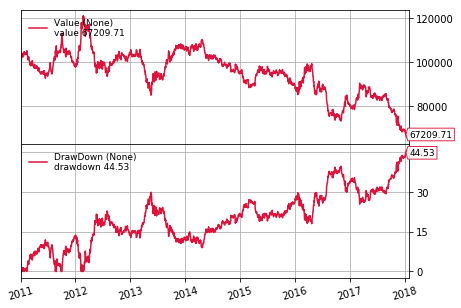

Sharpe Ratio:  -0.29954630588834974
SQN:  -0.865033333010458
Final Portfolio Value: 67209.71


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 6-2
2010-12-31, Close 2.22 0.78 29.12 0.00 4.00 0.31 6.34 1.17 1.30 0.30 7.31 3.02 1.25 11.73 0.00 0.00 0.00 2.20 4.11 1.97 7.26 0.41 0.00 4.83 0.00 11.03 1.71 0.52 0.00 0.40 0.00 0.00 0.96 0.00 0.00 0.61 12.77 0.84 0.50 0.00 0.66 2.75 1.36 0.00 1.18 0.68 0.99 1.32 0.59 0.70 1.00 0.43 0.00 0.00 4.00 5.94 0.00 3.03 
2010-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
2011-01-03, Buy 47970 Cache
2011-01-03, Buy 8735 ST_Engineering
2011-01-03, Buy 4004 Venture
2011-01-03, Buy 7821 Capitaland
2011-01-03, Sell 3221 Keppel_Corp
2011-01-03, Sell 11988 Genting
2011-01-03, Sell 17073 YZJ
2011-01-03, Sell 33446 Golden_Agri
2011-06-30, Close 2.30 0.82 35.02 0.00 4.28 0.37 5.73 1.34 1.32 0.29 8.05 3.01 1.27 9.78 0.00 0.00 0.00 1.99 4.10 1.73 6.

2014-01-01, OPERATION PROFIT, GROSS -2837.21, NET -2840.53
2014-01-01, OPERATION PROFIT, GROSS 99.78, NET 97.36
2014-01-01, OPERATION PROFIT, GROSS 1588.40, NET 1132.51
2014-06-30, Close 3.23 1.18 39.06 0.57 5.99 0.30 5.95 1.97 1.80 0.58 9.15 3.61 1.32 9.83 0.81 0.00 0.00 2.70 4.81 1.22 8.05 0.62 0.00 2.89 0.54 14.64 3.31 1.06 0.56 0.65 0.00 0.00 1.29 0.65 0.00 1.04 9.36 1.03 0.81 1.08 1.12 3.32 0.92 0.00 2.16 0.91 1.47 1.59 0.90 0.52 1.53 0.93 0.57 0.67 5.99 6.40 0.55 2.84 
2014-06-30, Current Positions: 0 0 454 0 0 47781 0 0 0 0 -1224 0 0 0 0 0 0 0 0 -8306 0 0 0 -3701 0 -772 0 0 27470 0 0 0 0 0 0 0 0 0 0 0 0 0 -11753 0 0 0 0 0 0 0 0 17613 0 0 0 0 0 0 
2014-07-01, Sell 47781 Lippo_Mall
2014-07-01, Buy 1224 Keppel_Corp
2014-07-01, Buy 772 DBS
2014-07-01, Sell 27470 Ascendas_Hos
2014-07-01, Sell 17613 First
2014-07-01, Buy 2141 SGX
2014-07-01, Buy 4653 SATS
2014-07-01, Buy 18696 Genting
2014-07-01, Buy 8081 Wilmar
2014-07-01, Sell 10789 Captret_China
2014-07-01, Sell 778 Jardine_C&C
201

2017-01-02, Buy 1824 Singtel
2017-01-02, Buy 9882 BHG
2017-01-02, Buy 2489 Starhub
2017-01-02, Buy 10741 Frasers_Hos
2017-01-02, Sell 217 YZJ
2017-01-02, Sell 61 ComfortDelGro
2017-01-02, Sell 5853 Keppel_Dc
2017-01-02, Sell 1353 SATS
2017-01-02, Sell 7241 Genting
2017-01-02, Sell 384 DBS
2017-01-02, Buy 5944 Golden_Agri
2017-01-02, Sell 693 Venture
2017-01-02, OPERATION PROFIT, GROSS -601.61, NET -822.42
2017-01-02, OPERATION PROFIT, GROSS -634.83, NET -636.38
2017-01-02, OPERATION PROFIT, GROSS 260.09, NET 258.93
2017-01-02, OPERATION PROFIT, GROSS -758.08, NET -759.15
2017-01-02, OPERATION PROFIT, GROSS -714.05, NET -934.77
2017-01-02, OPERATION PROFIT, GROSS 218.34, NET -2.40
2017-01-02, OPERATION PROFIT, GROSS 296.37, NET 75.65
2017-01-02, OPERATION PROFIT, GROSS 639.46, NET 418.78
2017-01-02, OPERATION PROFIT, GROSS -116.84, NET -117.98
2017-06-30, Close 3.72 1.59 42.90 0.82 7.49 0.43 7.08 2.57 2.46 0.55 6.11 3.13 1.52 10.66 0.93 0.73 1.22 4.94 3.03 1.05 10.47 0.43 0.78 3.25 0.70

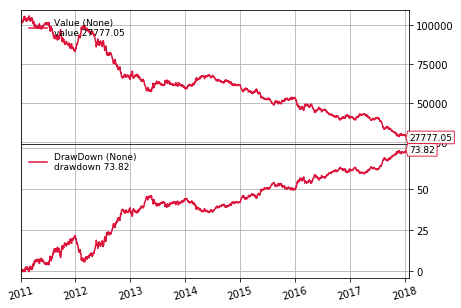

Sharpe Ratio:  -1.13222321056649
SQN:  -2.2271587224387983
Final Portfolio Value: 27777.05


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 6-1
2010-12-31, Close 2.22 0.78 29.12 0.00 4.00 0.31 6.34 1.17 1.30 0.30 7.31 3.02 1.25 11.73 0.00 0.00 0.00 2.20 4.11 1.97 7.26 0.41 0.00 4.83 0.00 11.03 1.71 0.52 0.00 0.40 0.00 0.00 0.96 0.00 0.00 0.61 12.77 0.84 0.50 0.00 0.66 2.75 1.36 0.00 1.18 0.68 0.99 1.32 0.59 0.70 1.00 0.43 0.00 0.00 4.00 5.94 0.00 3.03 
2010-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
2011-01-03, Buy 30552 Captret_China
2011-01-03, Buy 4928 Wilmar
2011-01-03, Buy 47970 Cache
2011-01-03, Buy 7821 Capitaland
2011-01-03, Sell 3221 Keppel_Corp
2011-01-03, Sell 11988 Genting
2011-01-03, Sell 17073 YZJ
2011-01-03, Sell 33446 Golden_Agri
2011-06-30, Close 2.30 0.82 35.02 0.00 4.28 0.37 5.73 1.34 1.32 0.29 8.05 3.01 1.27 9.78 0.00 0.00 0.00 1.99 4.10 1.73 6.99 

2014-01-01, OPERATION PROFIT, GROSS 1321.60, NET 718.93
2014-01-01, OPERATION PROFIT, GROSS 131.85, NET 128.65
2014-01-01, OPERATION PROFIT, GROSS 2099.75, NET 1497.10
2014-06-30, Close 3.23 1.18 39.06 0.57 5.99 0.30 5.95 1.97 1.80 0.58 9.15 3.61 1.32 9.83 0.81 0.00 0.00 2.70 4.81 1.22 8.05 0.62 0.00 2.89 0.54 14.64 3.31 1.06 0.56 0.65 0.00 0.00 1.29 0.65 0.00 1.04 9.36 1.03 0.81 1.08 1.12 3.32 0.92 0.00 2.16 0.91 1.47 1.59 0.90 0.52 1.53 0.93 0.57 0.67 5.99 6.40 0.55 2.84 
2014-06-30, Current Positions: 0 0 496 0 0 52178 0 0 0 0 0 0 0 1706 0 0 0 0 -3259 -11458 0 0 0 0 0 -1061 0 0 29998 0 0 0 0 0 0 0 0 0 0 0 0 0 -16213 0 -9113 0 0 0 0 0 0 19216 0 0 0 0 0 0 
2014-07-01, Sell 52178 Lippo_Mall
2014-07-01, Sell 1706 CityDev
2014-07-01, Buy 3259 Sembcorp_Ind
2014-07-01, Buy 1061 DBS
2014-07-01, Sell 29998 Ascendas_Hos
2014-07-01, Sell 19216 First
2014-07-01, Buy 2797 SGX
2014-07-01, Buy 25030 Genting
2014-07-01, Buy 5737 Wilmar
2014-07-01, Buy 5007 ST_Engineering
2014-07-01, Buy 33803 YZJ
2

2017-01-02, Buy 10817 Keppel
2017-01-02, Buy 7933 Mapletree_Comm
2017-01-02, Buy 6784 Mapletree_Ind
2017-01-02, Buy 6524 Suntec
2017-01-02, Buy 5516 Frasers_Cpoint
2017-01-02, Sell 1973 UOB
2017-01-02, Buy 15789 BHG
2017-01-02, Buy 3165 Sabana
2017-01-02, Buy 3977 Starhub
2017-01-02, Buy 905 YZJ
2017-01-02, Buy 317 ComfortDelGro
2017-01-02, Buy 5863 Captland_Mall
2017-01-02, Sell 259 Jardine_C&C
2017-01-02, Sell 2163 SATS
2017-01-02, Sell 11570 Genting
2017-01-02, Sell 613 DBS
2017-01-02, Sell 24796 Golden_Agri
2017-01-02, Sell 1108 Venture
2017-01-02, OPERATION PROFIT, GROSS 1117.44, NET 1115.69
2017-01-02, OPERATION PROFIT, GROSS -872.80, NET -1193.15
2017-01-02, OPERATION PROFIT, GROSS -822.31, NET -824.44
2017-01-02, OPERATION PROFIT, GROSS 316.77, NET -3.48
2017-01-02, OPERATION PROFIT, GROSS 429.97, NET 109.75
2017-01-02, OPERATION PROFIT, GROSS 347.51, NET 27.29
2017-01-02, OPERATION PROFIT, GROSS 564.16, NET 243.94
2017-01-02, OPERATION PROFIT, GROSS 927.73, NET 607.57
2017-01-

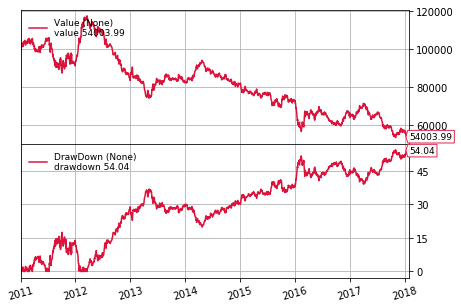

Sharpe Ratio:  -0.48032282880349475
SQN:  -1.0144553842210764
Final Portfolio Value: 54003.99


Starting Portfolio Value: 100000.00
Currently testing strategy MOM 2-1
2010-12-31, Close 2.22 0.78 29.12 0.00 4.00 0.31 6.34 1.17 1.30 0.30 7.31 3.02 1.25 11.73 0.00 0.00 0.00 2.20 4.11 1.97 7.26 0.41 0.00 4.83 0.00 11.03 1.71 0.52 0.00 0.40 0.00 0.00 0.96 0.00 0.00 0.61 12.77 0.84 0.50 0.00 0.66 2.75 1.36 0.00 1.18 0.68 0.99 1.32 0.59 0.70 1.00 0.43 0.00 0.00 4.00 5.94 0.00 3.03 
2010-12-31, Current Positions: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
2011-01-03, Buy 800 Jardine_C&C
2011-01-03, Buy 4928 Wilmar
2011-01-03, Buy 34496 Ascott
2011-01-03, Buy 7821 Capitaland
2011-01-03, Sell 3221 Keppel_Corp
2011-01-03, Sell 5760 Sembcorp_Ind
2011-01-03, Sell 3246 OCBC
2011-01-03, Sell 33446 Golden_Agri
2011-06-30, Close 2.30 0.82 35.02 0.00 4.28 0.37 5.73 1.34 1.32 0.29 8.05 3.01 1.27 9.78 0.00 0.00 0.00 1.99 4.10 1.73 6

2014-01-01, OPERATION PROFIT, GROSS -123.36, NET -514.00
2014-01-01, OPERATION PROFIT, GROSS 374.40, NET 372.33
2014-06-30, Close 3.23 1.18 39.06 0.57 5.99 0.30 5.95 1.97 1.80 0.58 9.15 3.61 1.32 9.83 0.81 0.00 0.00 2.70 4.81 1.22 8.05 0.62 0.00 2.89 0.54 14.64 3.31 1.06 0.56 0.65 0.00 0.00 1.29 0.65 0.00 1.04 9.36 1.03 0.81 1.08 1.12 3.32 0.92 0.00 2.16 0.91 1.47 1.59 0.90 0.52 1.53 0.93 0.57 0.67 5.99 6.40 0.55 2.84 
2014-06-30, Current Positions: 0 0 0 0 0 0 0 0 7367 0 -1329 0 0 1338 0 0 0 0 -2563 0 0 0 0 0 0 -833 0 0 0 0 0 0 0 0 0 12679 0 0 0 0 0 0 0 0 -7149 0 10084 0 0 23754 0 0 -23212 0 0 0 0 0 
2014-07-01, Sell 7367 Ascendas
2014-07-01, Buy 1329 Keppel_Corp
2014-07-01, Buy 2563 Sembcorp_Ind
2014-07-01, Buy 833 DBS
2014-07-01, Sell 12679 AIMS
2014-07-01, Sell 10084 Suntec
2014-07-01, Buy 23212 Soilbuild
2014-07-01, Buy 313 Jardine_C&C
2014-07-01, Buy 6199 Parkway
2014-07-01, Sell 91 CityDev
2014-07-01, Buy 4222 Wilmar
2014-07-01, Sell 205 Golden_Agri
2014-07-01, Sell 11492 Fraser

2017-01-02, Sell 1495 UOB
2017-01-02, Buy 1022 Venture
2017-01-02, Buy 6761 Captret_China
2017-01-02, Buy 5157 Sabana
2017-01-02, Buy 5706 Starhub
2017-01-02, Buy 6745 Mapletree_Comm
2017-01-02, Sell 1551 Keppel_Corp
2017-01-02, Sell 13398 BHG
2017-01-02, Sell 3098 Sembcorp_Ind
2017-01-02, Sell 21022 Genting
2017-01-02, Sell 520 DBS
2017-01-02, Sell 44637 Golden_Agri
2017-01-02, OPERATION PROFIT, GROSS 581.97, NET 339.45
2017-01-02, OPERATION PROFIT, GROSS 846.72, NET 845.39
2017-01-02, OPERATION PROFIT, GROSS -661.33, NET -904.07
2017-01-02, OPERATION PROFIT, GROSS 904.31, NET 902.99
2017-01-02, OPERATION PROFIT, GROSS 263.30, NET 20.67
2017-01-02, OPERATION PROFIT, GROSS 846.72, NET 845.39
2017-01-02, OPERATION PROFIT, GROSS -1441.91, NET -1684.61
2017-01-02, OPERATION PROFIT, GROSS 1906.91, NET 1664.48
2017-01-02, OPERATION PROFIT, GROSS 703.03, NET 460.41
2017-01-02, OPERATION PROFIT, GROSS 2260.44, NET 2259.00
2017-06-30, Close 3.72 1.59 42.90 0.82 7.49 0.43 7.08 2.57 2.46 0.55 6.

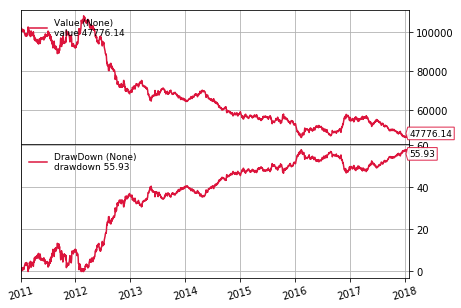

Sharpe Ratio:  -0.686777649568103
SQN:  -2.314290230024661
Final Portfolio Value: 47776.14




In [59]:
full_returns_dict = {}
full_values_dict = OrderedDict()

if __name__ == '__main__':
    
    for i in full_raw_dict.keys():
        
        # Create a cerebro entity
        cerebro = bt.Cerebro(stdstats=False)
        
        # Add the datafeeds into cerebro
        for key in full_raw_dict[i].keys():
            data = CustomDataLoader(dataname=full_raw_dict[i][key])
            data.plotinfo.plot = False
            cerebro.adddata(data, name=key)
    
        # Add a strategy and define our holding period
        cerebro.addstrategy(NewMomentumStrategy, period=6)
    
        # Set our desired cash start
        cerebro.broker.setcash(100000.0)
    
        # Set the commission
        cerebro.broker.setcommission(commission=0.00008, interest=0.06)
        cerebro.broker.set_checksubmit(False)

        # Add analyzers to cerebro
        #cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='ta')
        cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='mysharpe', riskfreerate=0.0, timeframe=bt.TimeFrame.Days)
        cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
        # Add observers to cerebro
        cerebro.addobserver(bt.observers.Value)
        cerebro.addobserver(bt.observers.DrawDown)

        # Print out the starting conditions
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('Currently testing strategy ' + str(i))
    
        # Run over everything
        strategies = cerebro.run()
        firstStrat = strategies[0]
    
        # Plot everything
        fig = cerebro.plot()
    
        # Print the analyzers
        #print('Trade Analysis' + firstStrat.analyzers.ta.get_analysis())
        print('Sharpe Ratio: ', firstStrat.analyzers.mysharpe.get_analysis()['sharperatio'])
        print('SQN: ', firstStrat.analyzers.sqn.get_analysis()['sqn'])
    
        # Get the pyfolio data and store it into a dictionary
        pyfoliozer = firstStrat.analyzers.pyfolio
        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        full_returns_dict[str(i)] = returns
        full_values_dict[str(i)] = cerebro.broker.getvalue()
    
        # Print out the final result
        print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('\n')


In [56]:
full_returns_dict_1M = full_returns_dict.copy()

In [58]:
full_returns_dict_3M = full_returns_dict.copy()

In [60]:
full_returns_dict_6M = full_returns_dict.copy()

## General Test Parameters:
- Backtesting period: 1/1/2011 to 1/31/2018
- Number of reits included in our portfolio: Long the top 10% and short the bottom 10%
- Comission cost: 0.08%
- Short interest rate: 6.00%
- Risk free rate: 0.00%

To benchmark our performance, we will be comparing it with the STI index.

### Test 1:
- Criteria: MOM 12-2 cumulative returns
- Holding period: 1/3/6 months

#### MOM 12-2 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -7.2%
Cumulative returns    -42.1%
Annual volatility      15.4%
Sharpe ratio           -0.41
Calmar ratio           -0.13
Stability               0.66
Max drawdown          -56.9%
Omega ratio             0.93
Sortino ratio          -0.58
Skew                    0.24
Kurtosis                1.99
Tail ratio              1.03
Daily value at risk    -2.0%
Alpha                  -0.08
Beta                    0.34

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  56.91 2012-03-19  2018-01-19           NaT   
1                                  13.17 2011-10-28  2012-01-02    2012-02-06   
2                                   5.61 2011-10-12  2011-10-20    2011-10-27   
3                                   5.54 2011-03-15  2011-04-12    2011-06-17   
4                                   5.47 2011-07-20  2011-08-04    2011-10-07   

Worst drawdown periods Duration  
0                           NaN  
1                            72  
2                            12  
3                            69  
4                            58

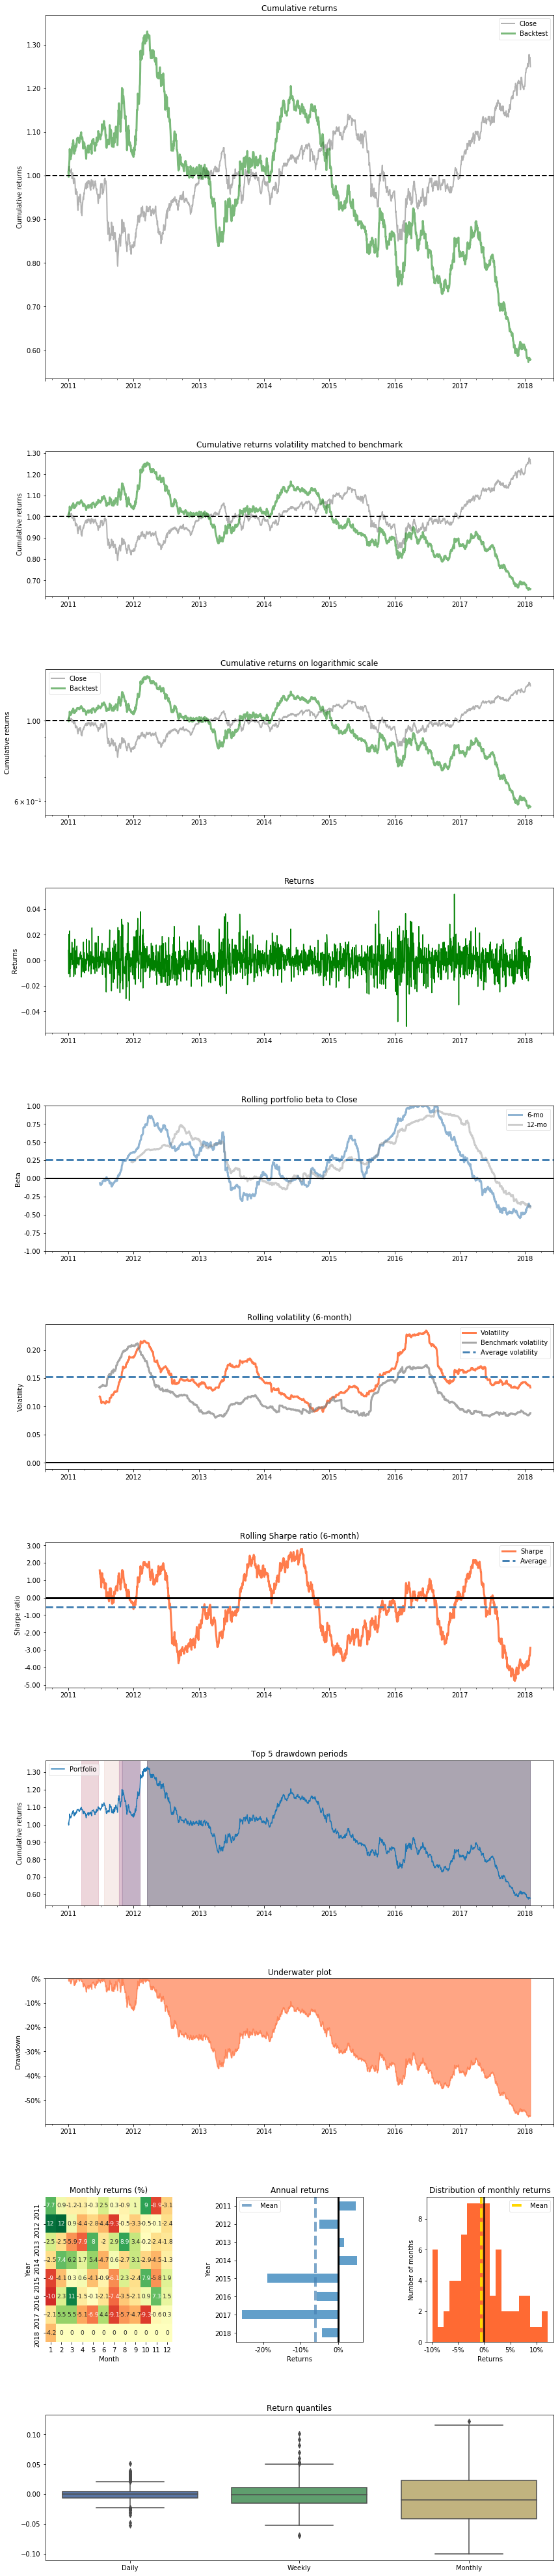

In [61]:
M12_2_1_returns = full_returns_dict_1M['MOM 12-2']
create_custom_tear_sheet(returns=M12_2_1_returns, benchmark_rets=sti_rets)

#### MOM 12-2 with 3 months holding period

Backtest months: 88


Backtest
Annual return         -10.5%
Cumulative returns    -55.8%
Annual volatility      16.0%
Sharpe ratio           -0.61
Calmar ratio           -0.16
Stability               0.76
Max drawdown          -66.4%
Omega ratio             0.90
Sortino ratio          -0.87
Skew                    0.26
Kurtosis                2.46
Tail ratio              1.05
Daily value at risk    -2.1%
Alpha                  -0.11
Beta                    0.39

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  66.44 2012-02-22  2018-01-19           NaT   
1                                  10.88 2011-11-14  2011-12-30    2012-01-25   
2                                   8.35 2011-07-20  2011-08-10    2011-10-10   
3                                   7.12 2011-01-28  2011-04-12    2011-07-20   
4                                   5.78 2011-10-12  2011-10-20    2011-10-27   

Worst drawdown periods Duration  
0                           NaN  
1                            53  
2                            59  
3                           124  
4                            12

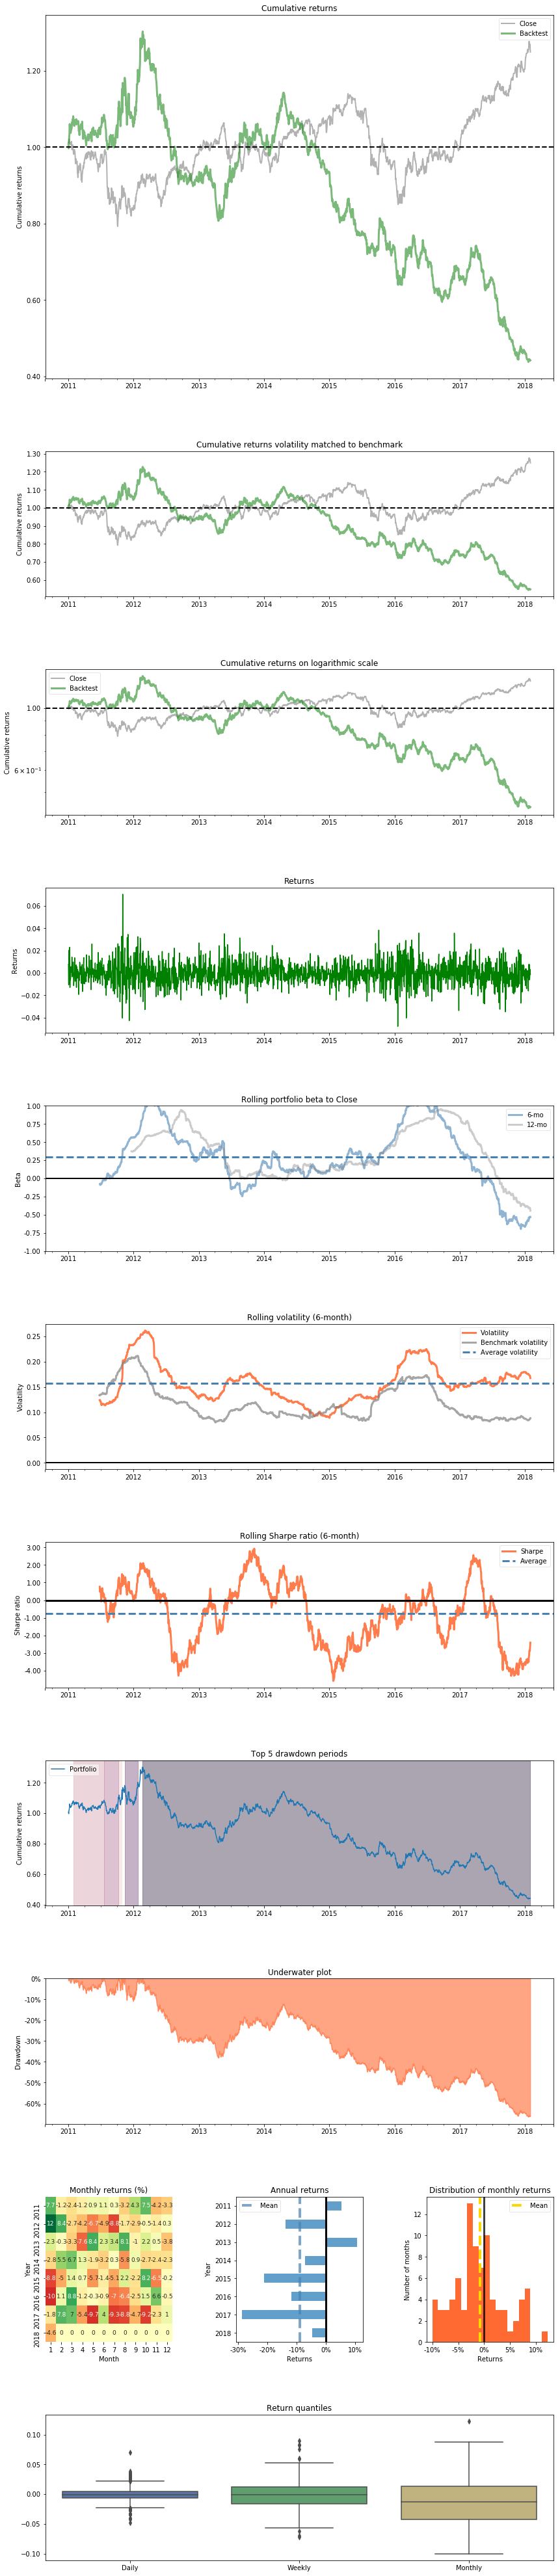

In [62]:
M12_2_3_returns = full_returns_dict_3M['MOM 12-2']
create_custom_tear_sheet(returns=M12_2_3_returns, benchmark_rets=sti_rets)

#### MOM 12-2 with 6 months holding period

Backtest months: 88


Backtest
Annual return         -17.3%
Cumulative returns    -75.2%
Annual volatility      15.7%
Sharpe ratio           -1.13
Calmar ratio           -0.22
Stability               0.91
Max drawdown          -77.8%
Omega ratio             0.83
Sortino ratio          -1.52
Skew                   -0.06
Kurtosis                1.69
Tail ratio              1.03
Daily value at risk    -2.1%
Alpha                  -0.19
Beta                    0.27

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  77.76 2012-02-22  2017-11-22           NaT   
1                                  17.30 2011-01-28  2012-01-02    2012-02-09   
2                                   2.20 2011-01-10  2011-01-14    2011-01-21   
3                                   2.14 2012-02-09  2012-02-10    2012-02-21   
4                                   1.06 2011-01-03  2011-01-04    2011-01-05   

Worst drawdown periods Duration  
0                           NaN  
1                           270  
2                            10  
3                             9  
4                             3

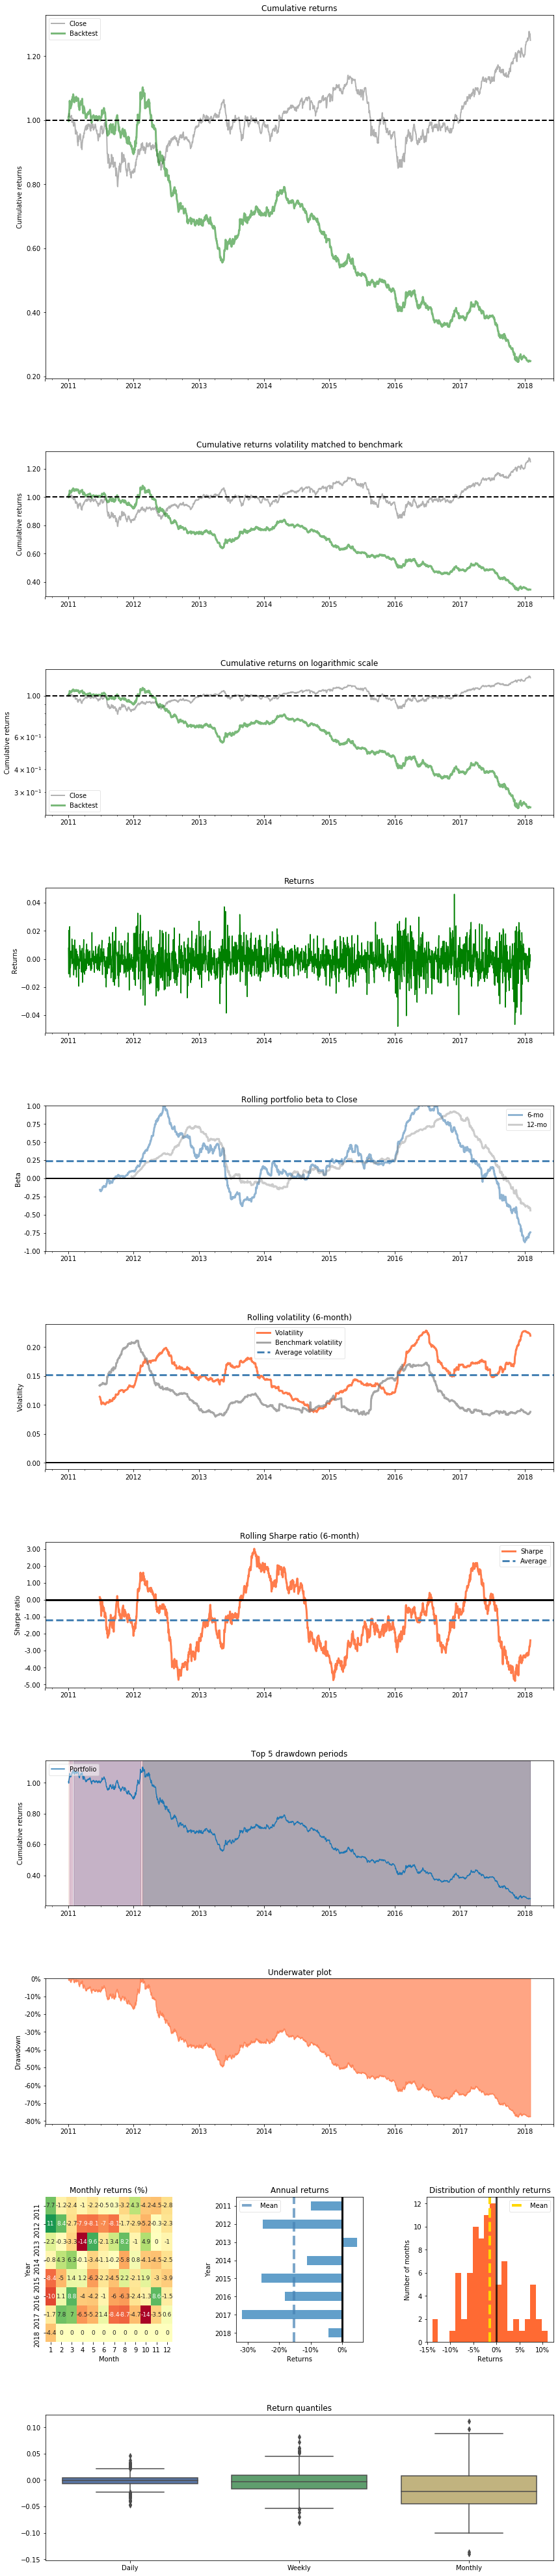

In [63]:
M12_2_6_returns = full_returns_dict_6M['MOM 12-2']
create_custom_tear_sheet(returns=M12_2_6_returns, benchmark_rets=sti_rets)

### Test 2:
- Criteria: MOM 12-7 cumulative returns
- Holding period: 1/3/6 months

#### MOM 12-7 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -5.6%
Cumulative returns    -34.6%
Annual volatility      14.2%
Sharpe ratio           -0.34
Calmar ratio           -0.14
Stability               0.70
Max drawdown          -41.3%
Omega ratio             0.94
Sortino ratio          -0.47
Skew                    0.10
Kurtosis                1.73
Tail ratio              1.00
Daily value at risk    -1.8%
Alpha                  -0.06
Beta                    0.20

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  41.31 2011-10-04  2018-01-15           NaT   
1                                  11.80 2011-02-11  2011-05-12    2011-10-03   
2                                   1.79 2011-01-26  2011-02-07    2011-02-10   
3                                   1.52 2011-01-12  2011-01-14    2011-01-24   
4                                   0.49 2011-01-10  2011-01-11    2011-01-12   

Worst drawdown periods Duration  
0                           NaN  
1                           167  
2                            12  
3                             9  
4                             3

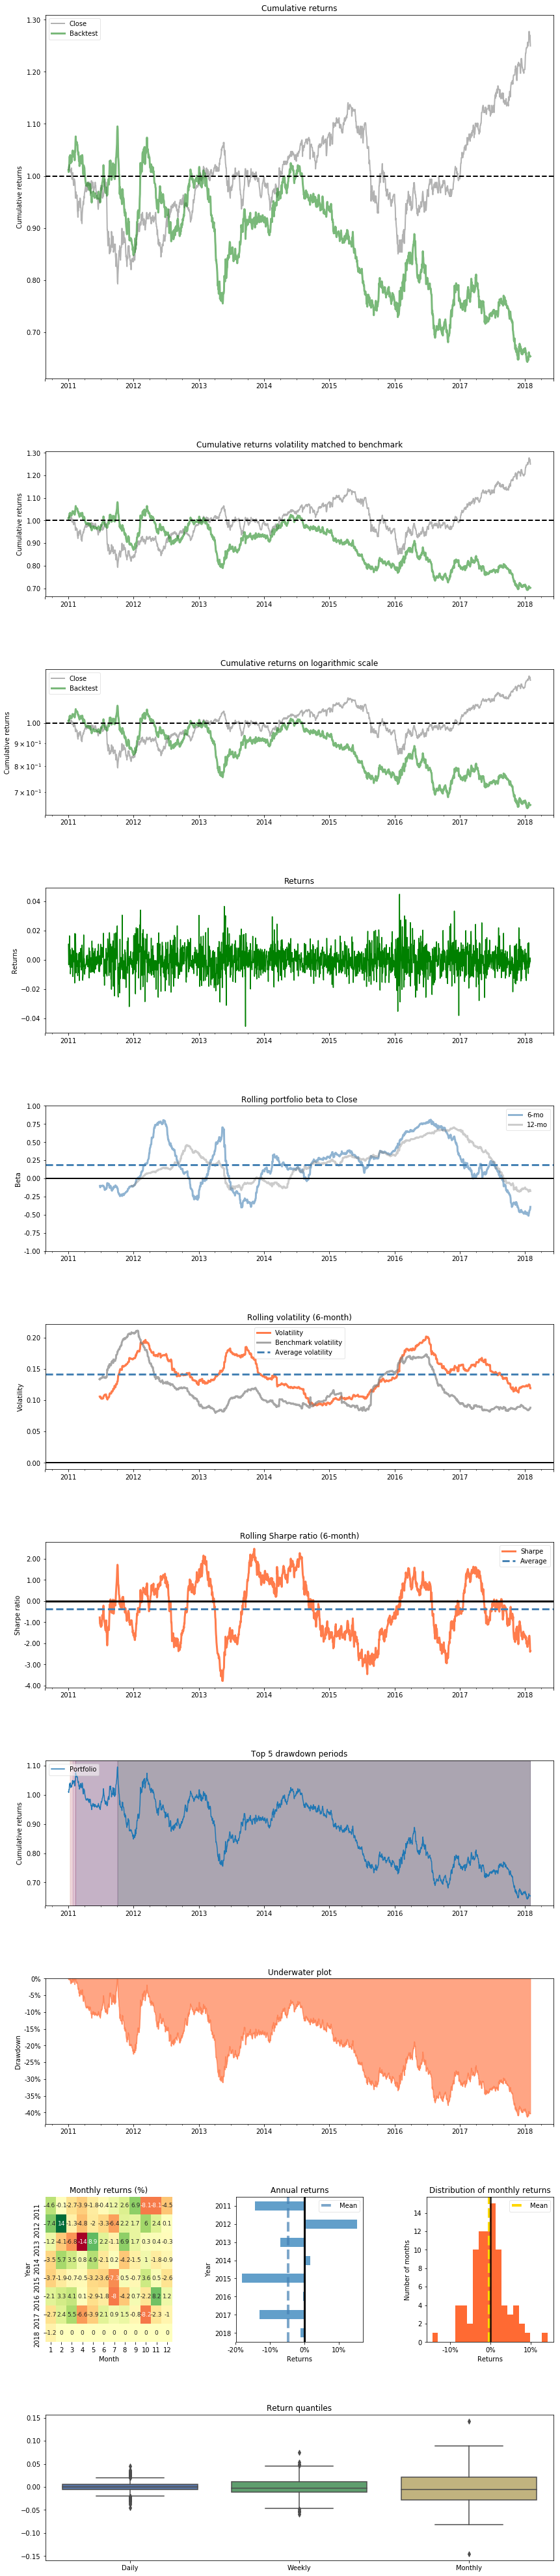

In [64]:
M12_7_1_returns = full_returns_dict_1M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_1_returns, benchmark_rets=sti_rets)

#### MOM 12-7 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -7.3%
Cumulative returns    -42.7%
Annual volatility      15.0%
Sharpe ratio           -0.43
Calmar ratio           -0.14
Stability               0.78
Max drawdown          -53.4%
Omega ratio             0.93
Sortino ratio          -0.61
Skew                    0.15
Kurtosis                1.47
Tail ratio              0.94
Daily value at risk    -1.9%
Alpha                  -0.07
Beta                    0.14

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  53.44 2011-10-04  2017-11-24           NaT   
1                                  10.71 2011-02-11  2011-05-12    2011-08-11   
2                                   4.69 2011-08-26  2011-08-31    2011-09-28   
3                                   1.55 2011-08-15  2011-08-17    2011-08-19   
4                                   1.52 2011-01-12  2011-01-14    2011-01-24   

Worst drawdown periods Duration  
0                           NaN  
1                           130  
2                            24  
3                             5  
4                             9

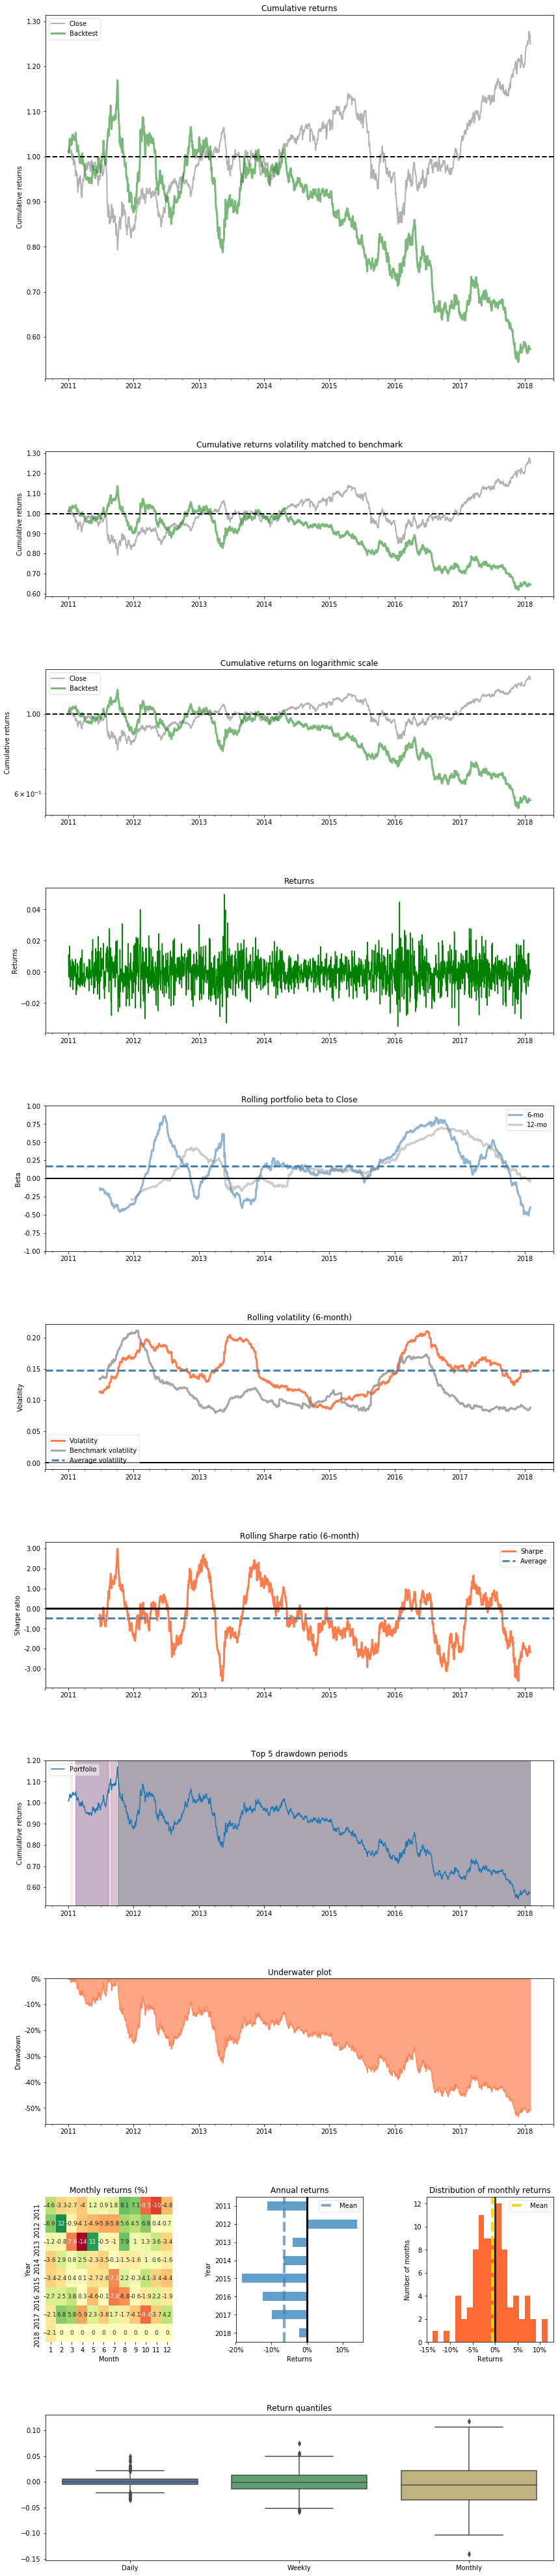

In [65]:
M12_7_3_returns = full_returns_dict_3M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_3_returns, benchmark_rets=sti_rets)

#### MOM 12-7 with 6 months holding period

Backtest months: 88


Backtest
Annual return          -5.3%
Cumulative returns    -32.8%
Annual volatility      14.6%
Sharpe ratio           -0.30
Calmar ratio           -0.12
Stability               0.58
Max drawdown          -45.7%
Omega ratio             0.95
Sortino ratio          -0.43
Skew                    0.23
Kurtosis                2.08
Tail ratio              0.99
Daily value at risk    -1.9%
Alpha                  -0.05
Beta                    0.09

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  45.69 2012-02-22  2018-01-15           NaT   
1                                  13.65 2011-10-04  2012-01-02    2012-02-08   
2                                  11.87 2011-02-11  2011-06-15    2011-08-24   
3                                   4.72 2011-08-26  2011-08-31    2011-09-28   
4                                   2.43 2012-02-09  2012-02-16    2012-02-20   

Worst drawdown periods Duration  
0                           NaN  
1                            92  
2                           139  
3                            24  
4                             8

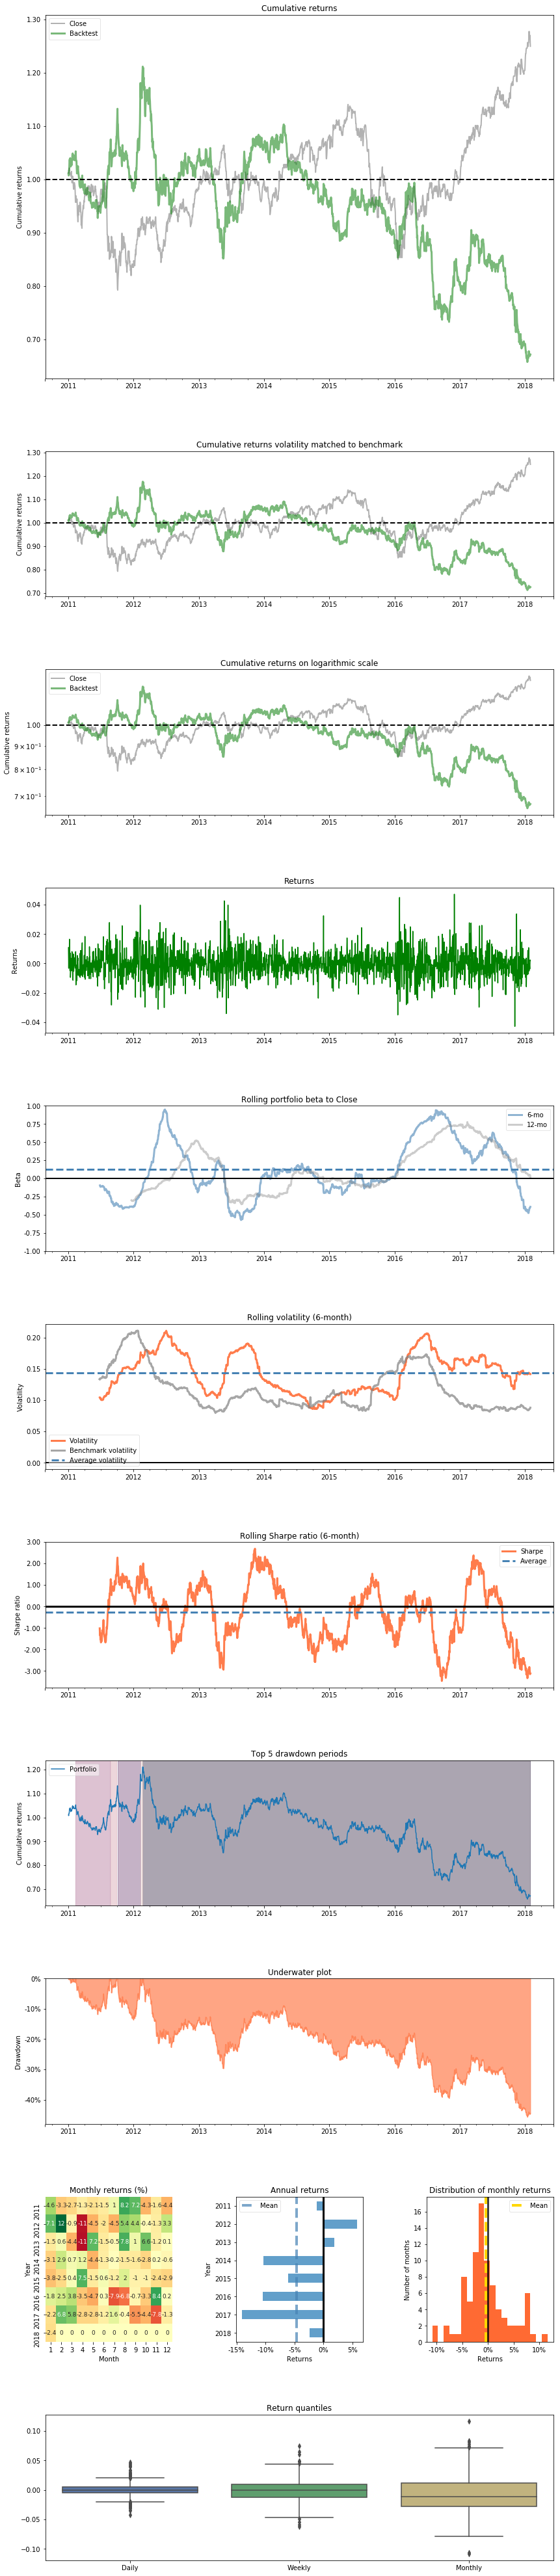

In [66]:
M12_7_6_returns = full_returns_dict_6M['MOM 12-7']
create_custom_tear_sheet(returns=M12_7_6_returns, benchmark_rets=sti_rets)

### Test 3:
- Criteria: MOM 6-2 cumulative returns
- Holding period: 1/3/6 months

#### MOM 6-2 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -6.6%
Cumulative returns    -39.3%
Annual volatility      14.4%
Sharpe ratio           -0.40
Calmar ratio           -0.14
Stability               0.73
Max drawdown          -48.1%
Omega ratio             0.93
Sortino ratio          -0.57
Skew                    0.20
Kurtosis                1.58
Tail ratio              1.03
Daily value at risk    -1.8%
Alpha                  -0.07
Beta                    0.20

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  48.07 2012-05-09  2018-01-29           NaT   
1                                  18.81 2011-02-24  2011-09-13    2012-02-09   
2                                   3.88 2012-03-07  2012-03-15    2012-05-03   
3                                   3.07 2011-01-31  2011-02-04    2011-02-21   
4                                   2.15 2012-02-15  2012-02-17    2012-02-27   

Worst drawdown periods Duration  
0                           NaN  
1                           251  
2                            42  
3                            16  
4                             9

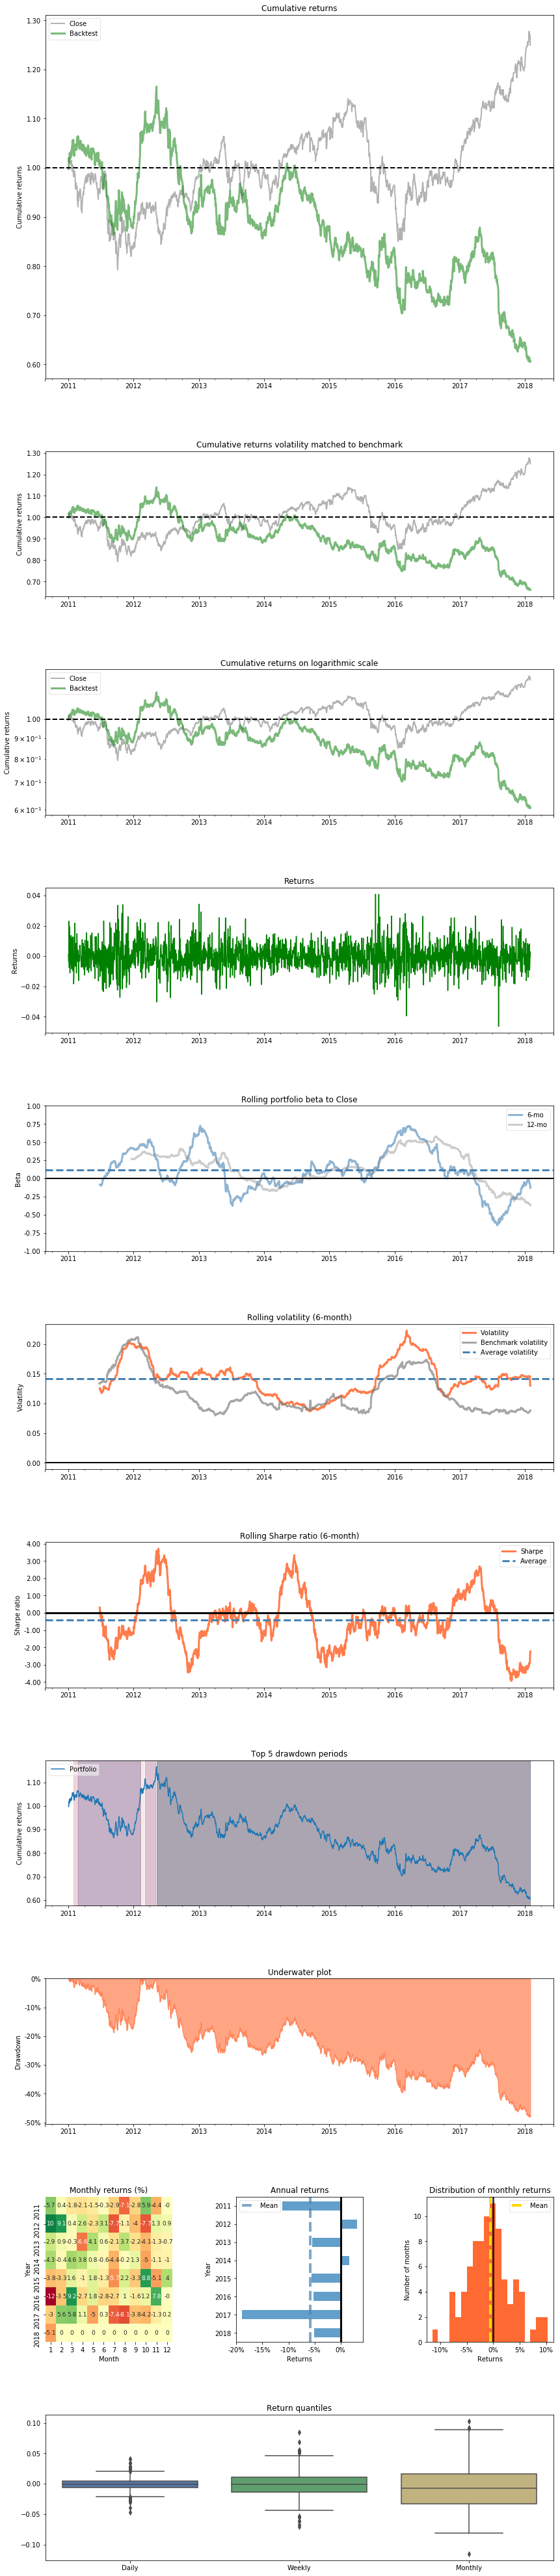

In [67]:
M6_2_1_returns = full_returns_dict_1M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_1_returns, benchmark_rets=sti_rets)

#### MOM 6-2 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -8.1%
Cumulative returns    -46.1%
Annual volatility      14.8%
Sharpe ratio           -0.49
Calmar ratio           -0.15
Stability               0.79
Max drawdown          -53.5%
Omega ratio             0.92
Sortino ratio          -0.70
Skew                    0.45
Kurtosis                3.57
Tail ratio              1.00
Daily value at risk    -1.9%
Alpha                  -0.08
Beta                    0.26

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  53.53 2012-05-18  2018-01-29           NaT   
1                                  16.50 2011-02-25  2011-10-04    2012-02-09   
2                                   3.59 2012-03-02  2012-03-22    2012-04-09   
3                                   2.75 2011-01-31  2011-02-11    2011-02-24   
4                                   1.63 2012-04-11  2012-04-19    2012-04-24   

Worst drawdown periods Duration  
0                           NaN  
1                           250  
2                            27  
3                            19  
4                            10

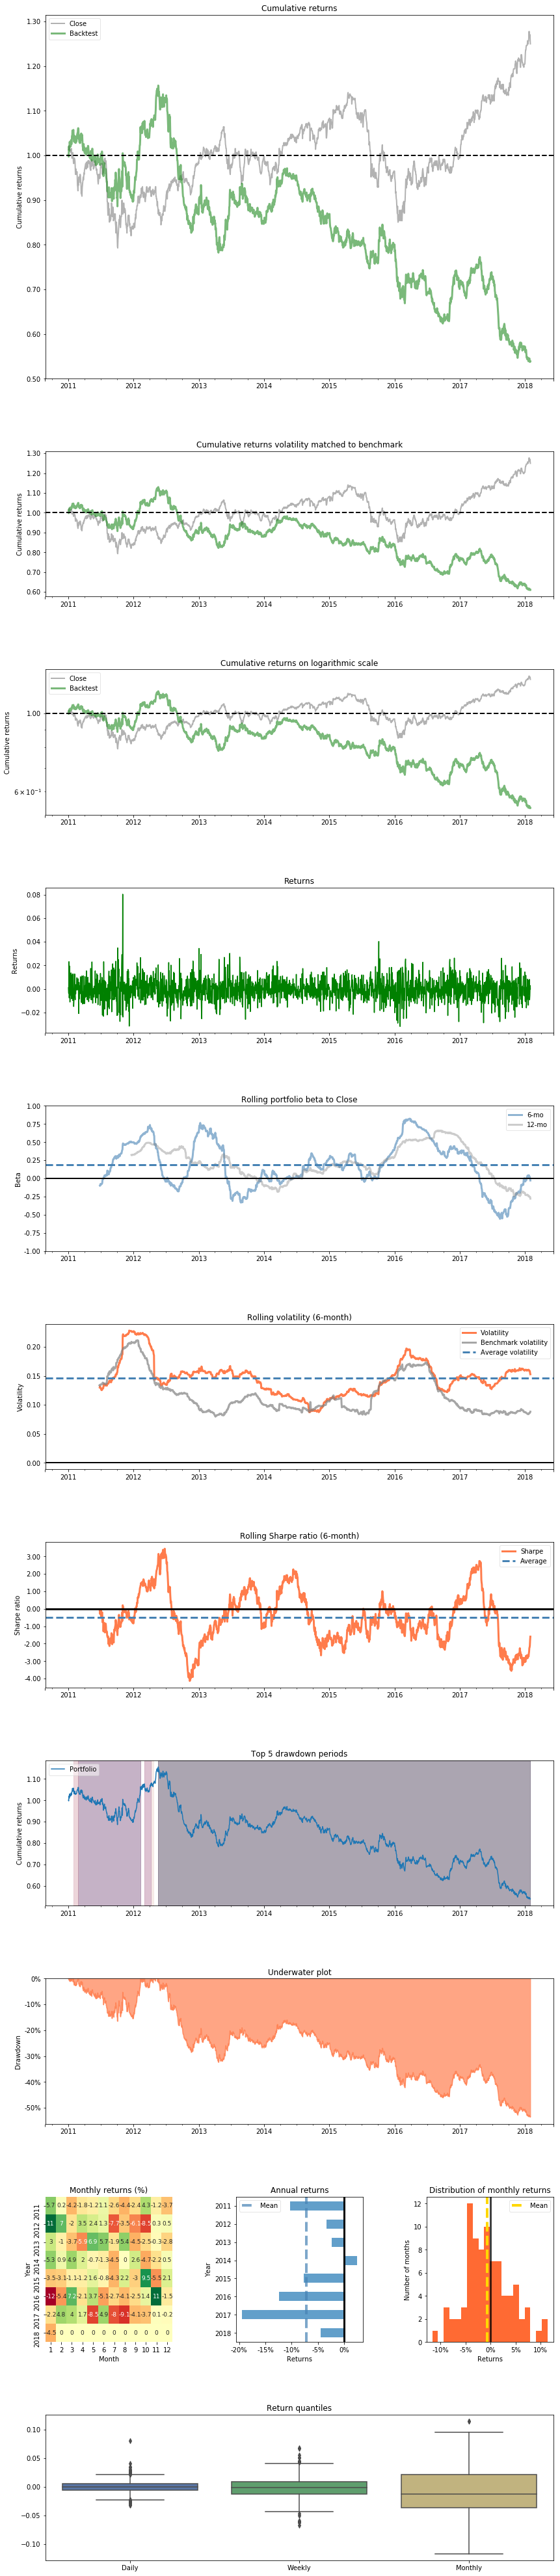

In [68]:
M6_2_3_returns = full_returns_dict_3M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_3_returns, benchmark_rets=sti_rets)

#### MOM 6-2 with 6 months holding period

Backtest months: 88


Backtest
Annual return         -16.0%
Cumulative returns    -72.2%
Annual volatility      14.5%
Sharpe ratio           -1.13
Calmar ratio           -0.22
Stability               0.94
Max drawdown          -73.9%
Omega ratio             0.83
Sortino ratio          -1.52
Skew                   -0.03
Kurtosis                1.15
Tail ratio              0.93
Daily value at risk    -1.9%
Alpha                  -0.17
Beta                    0.23

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  73.89 2011-02-25  2018-01-29           NaT   
1                                   2.75 2011-01-31  2011-02-11    2011-02-24   
2                                   1.27 2011-01-25  2011-01-27    2011-01-31   
3                                   1.11 2011-01-10  2011-01-11    2011-01-17   
4                                   0.93 2011-01-05  2011-01-07    2011-01-10   

Worst drawdown periods Duration  
0                           NaN  
1                            19  
2                             5  
3                             6  
4                             4

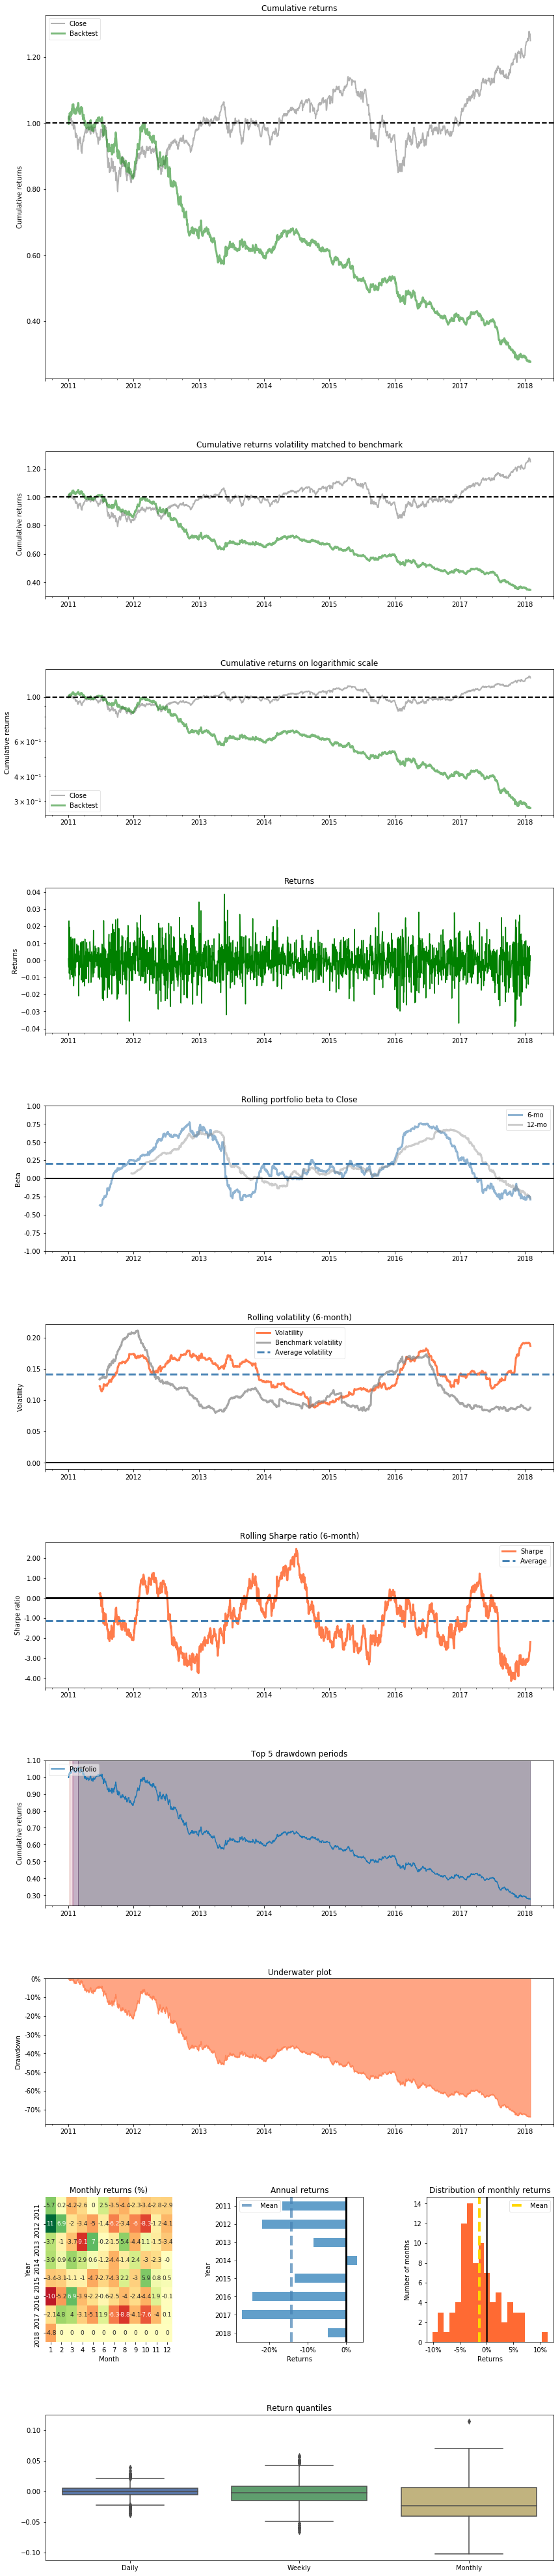

In [69]:
M6_2_6_returns = full_returns_dict_6M['MOM 6-2']
create_custom_tear_sheet(returns=M6_2_6_returns, benchmark_rets=sti_rets)

### Test 4:
- Criteria: MOM 2-1 cumulative returns
- Holding period: 1/3/6 months

#### MOM 2-1 with 1 month holding period

Backtest months: 88


Backtest
Annual return          -2.6%
Cumulative returns    -17.6%
Annual volatility      14.3%
Sharpe ratio           -0.11
Calmar ratio           -0.09
Stability               0.54
Max drawdown          -29.2%
Omega ratio             0.98
Sortino ratio          -0.16
Skew                    0.19
Kurtosis                1.59
Tail ratio              1.00
Daily value at risk    -1.8%
Alpha                  -0.02
Beta                    0.22

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  29.16 2011-06-01  2016-02-11           NaT   
1                                   4.93 2011-01-05  2011-02-11    2011-03-07   
2                                   4.36 2011-04-20  2011-05-02    2011-05-23   
3                                   3.86 2011-03-08  2011-03-18    2011-04-06   
4                                   1.03 2011-04-11  2011-04-12    2011-04-14   

Worst drawdown periods Duration  
0                           NaN  
1                            44  
2                            24  
3                            22  
4                             4

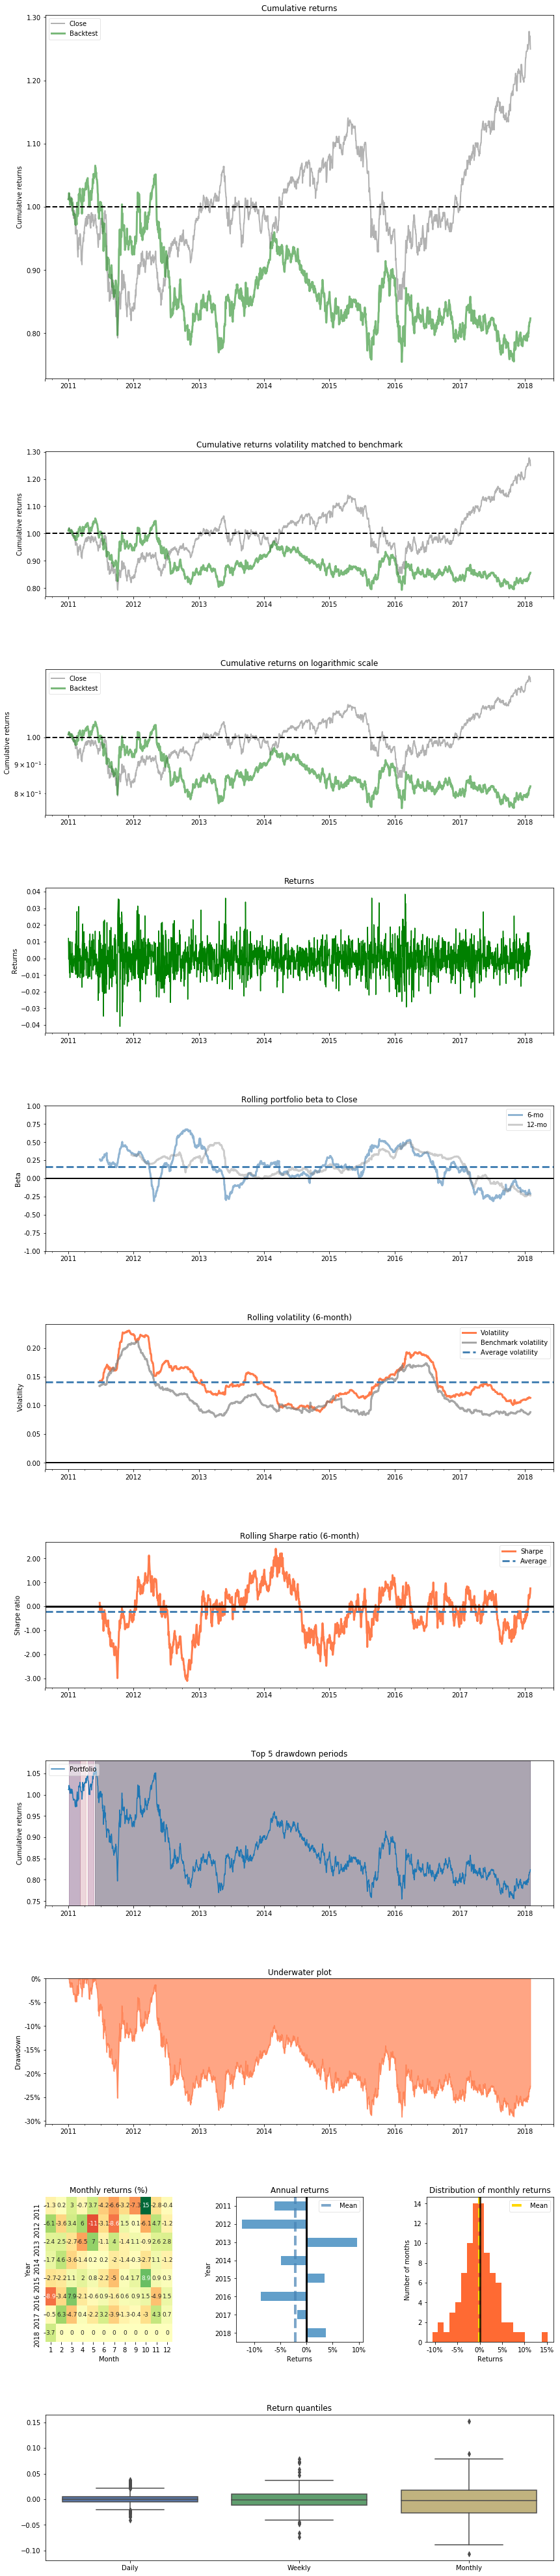

In [70]:
M2_1_1_returns = full_returns_dict_1M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_1_returns, benchmark_rets=sti_rets)

#### MOM 2-1 with 3 months holding period

Backtest months: 88


Backtest
Annual return          -6.5%
Cumulative returns    -39.1%
Annual volatility      14.1%
Sharpe ratio           -0.41
Calmar ratio           -0.14
Stability               0.73
Max drawdown          -46.8%
Omega ratio             0.93
Sortino ratio          -0.58
Skew                    0.09
Kurtosis                2.06
Tail ratio              1.01
Daily value at risk    -1.8%
Alpha                  -0.06
Beta                    0.17

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  46.79 2012-05-18  2018-01-12           NaT   
1                                  29.95 2011-02-21  2011-10-04    2012-04-27   
2                                   4.24 2011-01-05  2011-02-10    2011-02-21   
3                                   0.77 2012-05-14  2012-05-15    2012-05-16   
4                                   0.35 2012-05-09  2012-05-11    2012-05-14   

Worst drawdown periods Duration  
0                           NaN  
1                           310  
2                            34  
3                             3  
4                             4

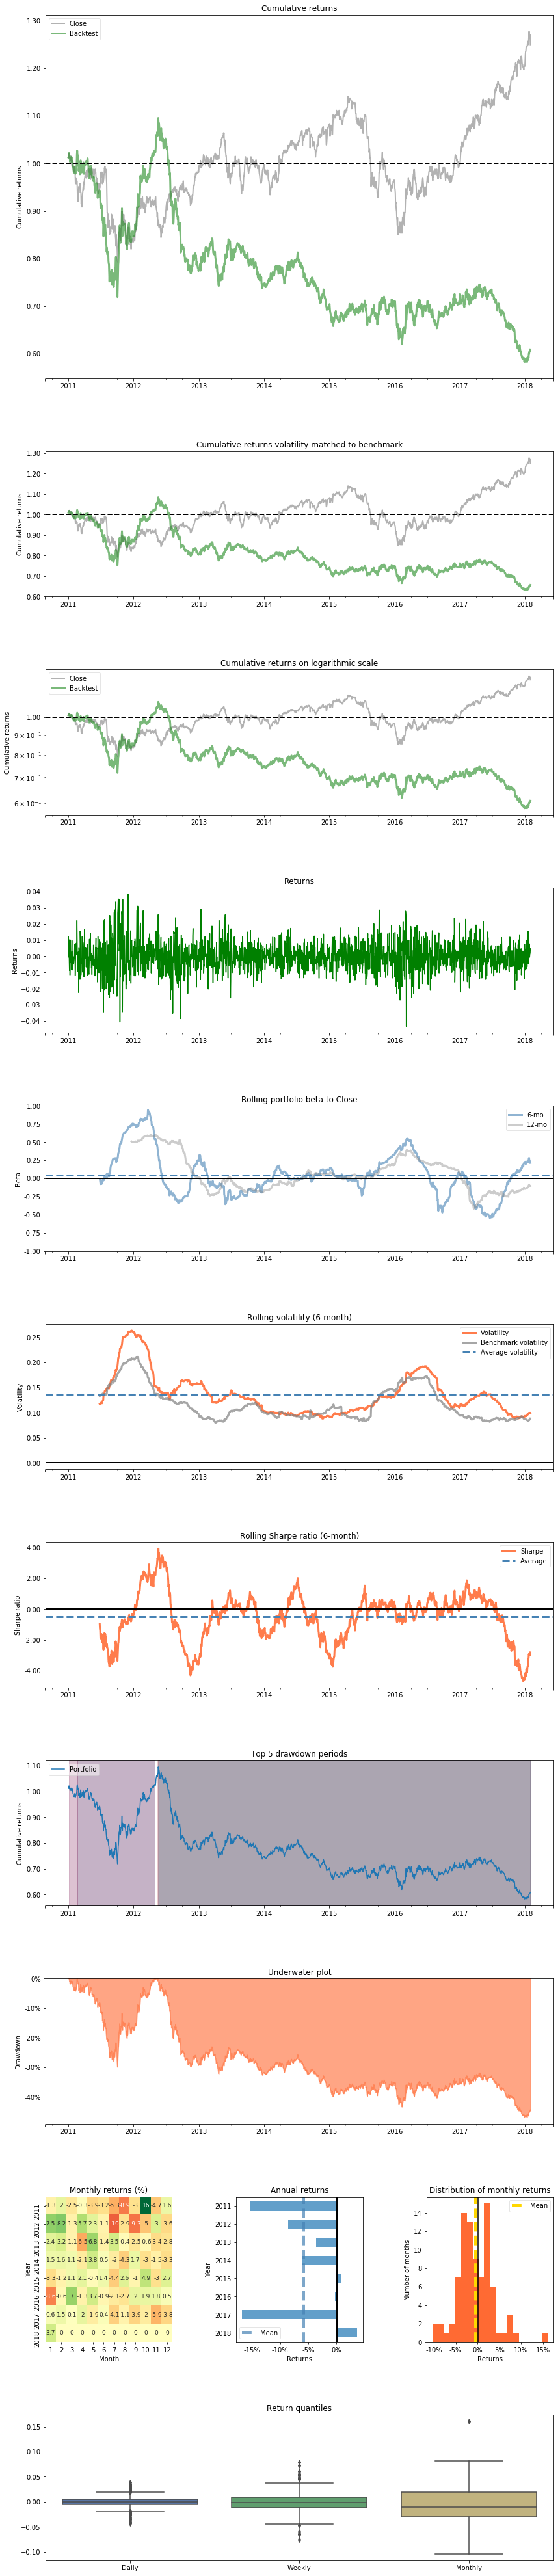

In [71]:
M2_1_3_returns = full_returns_dict_3M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_3_returns, benchmark_rets=sti_rets)

#### MOM 2-1 with 6 months holding period

Backtest months: 88


Backtest
Annual return          -9.6%
Cumulative returns    -52.2%
Annual volatility      13.4%
Sharpe ratio           -0.69
Calmar ratio           -0.17
Stability               0.88
Max drawdown          -57.9%
Omega ratio             0.89
Sortino ratio          -0.97
Skew                    0.33
Kurtosis                2.51
Tail ratio              1.03
Daily value at risk    -1.7%
Alpha                  -0.10
Beta                    0.12

Worst drawdown periods Net drawdown in %  Peak date Valley date Recovery date  \
0                                  57.90 2012-02-24  2016-02-11           NaT   
1                                  13.41 2011-02-21  2011-09-02    2012-02-08   
2                                   4.24 2011-01-05  2011-02-10    2011-02-21   
3                                   1.30 2012-02-09  2012-02-17    2012-02-21   
4                                   1.27 2012-02-22  2012-02-23    2012-02-24   

Worst drawdown periods Duration  
0                           NaN  
1                           253  
2                            34  
3                             9  
4                             3

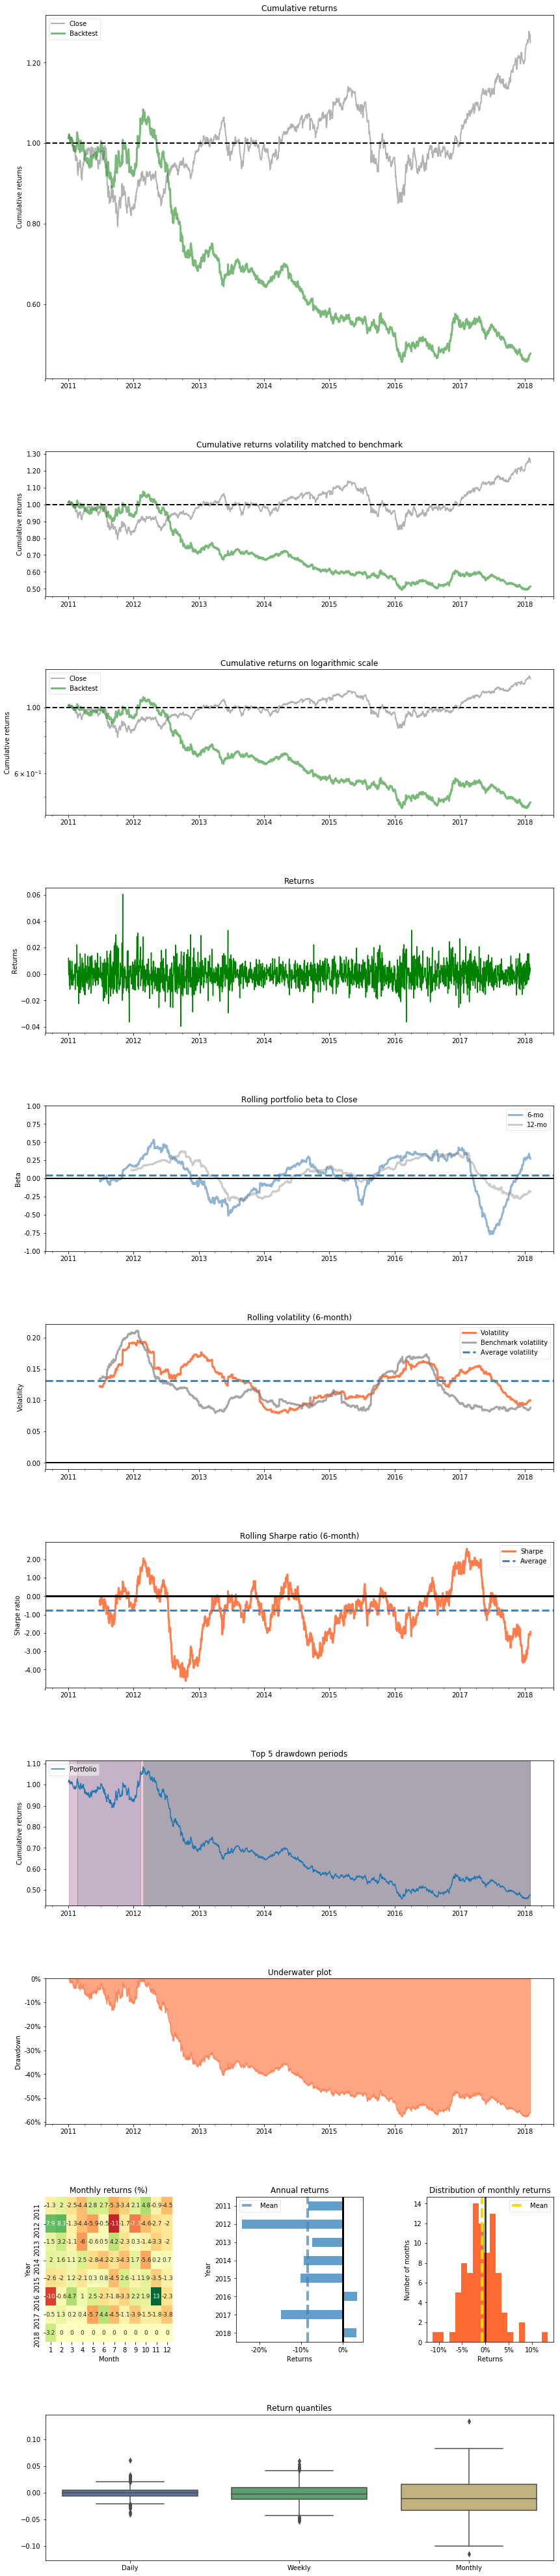

In [72]:
M2_1_6_returns = full_returns_dict_6M['MOM 2-1']
create_custom_tear_sheet(returns=M2_1_6_returns, benchmark_rets=sti_rets)

# Conclusion:

As we can see, the cross-sectional momentum strategy seems to have performed poorly for our backtest. Despite trying a range of parameters, we are unable to find a single strategy that can outperform a naive buy and hold. Therefore, we can rule out using the cross-sectional momentum anomaly strategy for STI stocks and reits.

In fact, for our chosen list of stocks, going long the worst performing stocks and going short the best performing stocks would have done much better!